# FESDModel - Model Evaluation

FESD - Fault estimation for skeleton detection - is a suite that aims at finding faults in joints of skeletons, which are detected by human pose estimatiors.

FESDData is the sister project to this notebook, which aims at recording depth and rgb data, as well as populating the data with human poses from variing human pose estimators.

Furthermore, FESTData augments all data based on joint confidence.

FFESDModel aims to develop and evaluate a model based on the faulty and augmented joint data as well as RGBD data.

## Libraries

We need a range of libraries which are imported here. We also define some constants.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from time import time

from data import FESDDataset
from data import Frame, AugmentationParams
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set()

import cv2

from model import FESD, train, val, test
import copy

import scipy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datetime

import torch

from utils.mode import Mode
from utils import err2gt, gt2err

from tqdm.notebook import tqdm

In [3]:
RECORDING_DIR = Path('D:/Recordings/')
CHECKPOINT_DIR = Path('checkpoints')

## Metadata Loading

Firstly we need to import all the recordings into the notebook.


In [4]:
with open(file="Exercises.json", mode='r') as file:
  exercises_json = json.load(file)['Exercises']

with open(file="JointErrors.json", mode='r') as file:
  joint_error_json = json.load(file)

with open(file="SkeletonErrors.json", mode='r') as file:
  skeleton_error_json = json.load(file)

len(exercises_json)

13

In [5]:
joint_names_all = ["-", "Head", "Neck", "Torso", "Waist", "Left collar", "Left shoulder", "Left ebpow", "Left wrist", "Left hand", "-", "Right collar", "Right shoulder", "Right elbow", "Right wrist", "Right hand", "-", "Left hip", "Left knee", "Left ankle", "-", "Right hip", "Right knee", "Right ankle", "-"]
joint_names = [i for i in joint_names_all if i != '-']

body_halves = np.array(["Upper Half", "Lower Half"])
body_parts = np.array(["Head", "Torso", "Left arm", "Right arm", "Left leg", "Right leg"])

upper_body_i = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
lower_body_i = [3, 14, 15, 16, 17, 18, 19]

torso_i     = [2, 3, 4, 9]
head_i      = [0, 1]
left_arm_i  = [5, 6, 7, 8]
right_arm_i = [10, 11, 12, 13]
left_leg_i  = [14, 15, 16]
right_leg_i = [17, 18, 19]

joint_errors = []
for je in joint_error_json:
  joint_errors.append(je["Name"])

## Model Evaluation

Here we create all graphs and analysis for the training

In [100]:
all_results = os.listdir("./results")
all_results

['v1_bs_60_is_64_e_100', 'v2_bs_40_is_64_e_100']

In [101]:
result_i = 0
result_dir = Path(f"./figures/results/{all_results[result_i]}")
result_dir.mkdir(parents=True, exist_ok=True)
(result_dir / "fb").mkdir(parents=True, exist_ok=True)
(result_dir / "hb").mkdir(parents=True, exist_ok=True)
(result_dir / "bp").mkdir(parents=True, exist_ok=True)
(result_dir / "jt").mkdir(parents=True, exist_ok=True)
(result_dir / "confusion").mkdir(parents=True, exist_ok=True)
result_dir

WindowsPath('figures/results/v1_bs_60_is_64_e_100')

In [102]:
# Load the results of training and testing

df_model = pd.read_parquet(f'./results/{all_results[result_i]}/ModelAnalysis.parquet.gzip')
df_model["difficulty"] = df_model.apply(lambda x: int(x["exercise"][2]), axis=1)
df_model["mode"] = df_model["mode"].apply(lambda x: Mode.from_str(mode_str=x))
df_model.head()

,epoch,iteration,joint_id,gts,preds,confidences,Avg loss,loss,accuracy,tp,...,recall,f1,cohens_kappa,learning_rate,train_test,exercise,simplified,mode,use_v2,difficulty
0,1,1,0,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0.832798957824707, 0.7724133729934692, 0.9872...",0.816498,0.816498,0.583333,31.0,...,0.885714,0.712644,0.050633,0.00005,train,E-3.01,True,Mode.BODY_PARTS,False,3
1,1,1,1,"[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0.9554452896118164, 0.7986970543861389, 0.840...",0.816498,0.816498,0.466667,16.0,...,0.410256,0.500000,-0.015873,0.00005,train,E-3.01,True,Mode.BODY_PARTS,False,3
2,1,1,2,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[0.9878707528114319, 0.9897494912147522, 0.504...",0.816498,0.816498,0.466667,10.0,...,0.294118,0.384615,-0.012658,0.00005,train,E-3.01,True,Mode.BODY_PARTS,False,3
3,1,1,3,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.910988986492157, 0.8982670903205872, 0.5332...",0.816498,0.816498,0.500000,7.0,...,0.218750,0.318182,0.038462,0.00005,train,E-3.01,True,Mode.BODY_PARTS,False,3
4,1,1,4,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7954862117767334, 0.9986156225204468, 0.985...",0.816498,0.816498,0.466667,24.0,...,0.705882,0.600000,-0.148325,0.00005,train,E-3.01,True,Mode.BODY_PARTS,False,3


In [103]:
tp = df_model["tp"]
tn = df_model["tn"]
fp = df_model["fp"]
fn = df_model["fn"]
df_model["binary_kappa"] = (2 * (tp * tn) - (fn * fp)) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))

In [104]:
df_model["p"] = df_model["tp"] + df_model["fp"]
df_model["n"] = df_model["tn"] + df_model["fn"]
df_model["p/(p+n)"] = df_model["p"] / (df_model["n"] + df_model["p"])

In [105]:
coi = ["difficulty", "p/(p+n)", "accuracy", "precision", "recall", "f1", "cohens_kappa"]
coi_tf_pn = ["tp", "tn", "fp", "fn", "p", "n"]

### Training Evaluation

In [106]:
df_model_train = df_model#[df_model["train_test"] == "train"]

#### Full Body Model

In [107]:
df_model_train_fb = df_model_train[df_model_train["mode"] == Mode.FULL_BODY]

In [108]:
df_model_train_fb["color"] = df_model_train_fb["train_test"].apply(lambda x: "C0" if x == "train" else "C1")

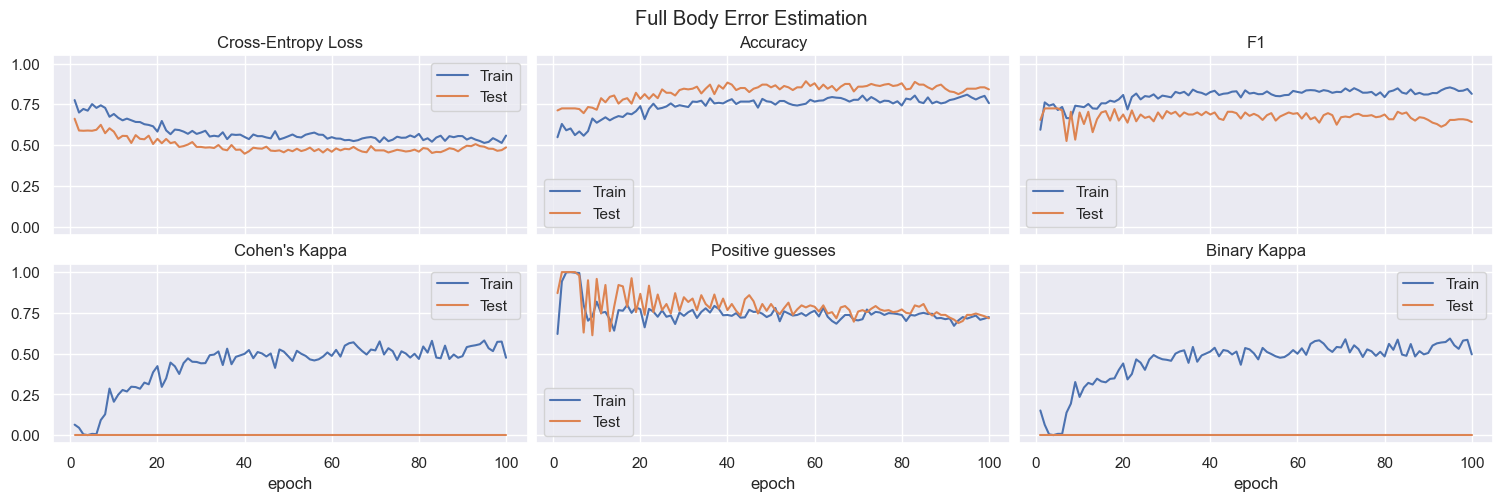

In [109]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=(15, 10))

fb_train = df_model_train_fb[df_model_train_fb["train_test"] == "train"]
fb_test = df_model_train_fb[df_model_train_fb["train_test"] == "test"]

fb_train[["epoch", "loss"]].groupby("epoch").mean().plot(y="loss", figsize=(15, 5), title="Cross-Entropy Loss", ax=axs[0][0])
fb_test[["epoch", "loss"]].groupby("epoch").mean().plot(y="loss", figsize=(15, 5), title="Cross-Entropy Loss", ax=axs[0][0])

fb_train[["epoch", "accuracy"]].groupby("epoch").mean().plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1])
fb_test[["epoch", "accuracy"]].groupby("epoch").mean().plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1])

fb_train[["epoch", "f1"]].groupby("epoch").mean().plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2])
fb_test[["epoch", "f1"]].groupby("epoch").mean().plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2])

fb_train[["epoch", "cohens_kappa"]].groupby("epoch").mean().plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0])
fb_test[["epoch", "cohens_kappa"]].groupby("epoch").mean().plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0])

fb_train[["epoch", "p/(p+n)"]].groupby("epoch").mean().plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1])
fb_test[["epoch", "p/(p+n)"]].groupby("epoch").mean().plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1])

# fig.delaxes(axs[1][2])
fb_train[["epoch", "binary_kappa"]].groupby("epoch").mean().plot(y="binary_kappa" , figsize=(15, 5), title="Binary Kappa", ax=axs[1][2])
fb_test[["epoch", "binary_kappa"]].groupby("epoch").mean().plot(y="binary_kappa" , figsize=(15, 5), title="Binary Kappa", ax=axs[1][2])

for ax in axs.flatten():
  ax.legend(["Train", "Test"])

fig.suptitle("Full Body Error Estimation")

fig.tight_layout(pad=.5)
plt.savefig(result_dir / "fb/FullBody_ErrorEstimation.png", dpi=300, bbox_inches='tight')
plt.show()

#### Half Body

In [110]:
df_model_train_hb = df_model_train[df_model_train["mode"] == Mode.HALF_BODY]
df_model_train_hb["joint"] = df_model_train_hb["joint_id"].apply(lambda x: body_halves[x])

C:\Users\leona\AppData\Local\Temp\ipykernel_25680\1512788436.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals_lh_tr = df_model_train_hb[df_model_train_hb["joint"] == "Lower Half"][df_model_train_hb["train_test"] == "train"]
C:\Users\leona\AppData\Local\Temp\ipykernel_25680\1512788436.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals_lh_te = df_model_train_hb[df_model_train_hb["joint"] == "Lower Half"][df_model_train_hb["train_test"] == "test"]
C:\Users\leona\AppData\Local\Temp\ipykernel_25680\1512788436.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals_uh_tr = df_model_train_hb[df_model_train_hb["joint"] == "Upper Half"][df_model_train_hb["train_test"] == "train"]
C:\Users\leona\AppData\Local\Temp\ipykernel_25680\1512788436.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vals_uh_te = df_model_train_hb[df_model_train_hb["joint"] == "Up

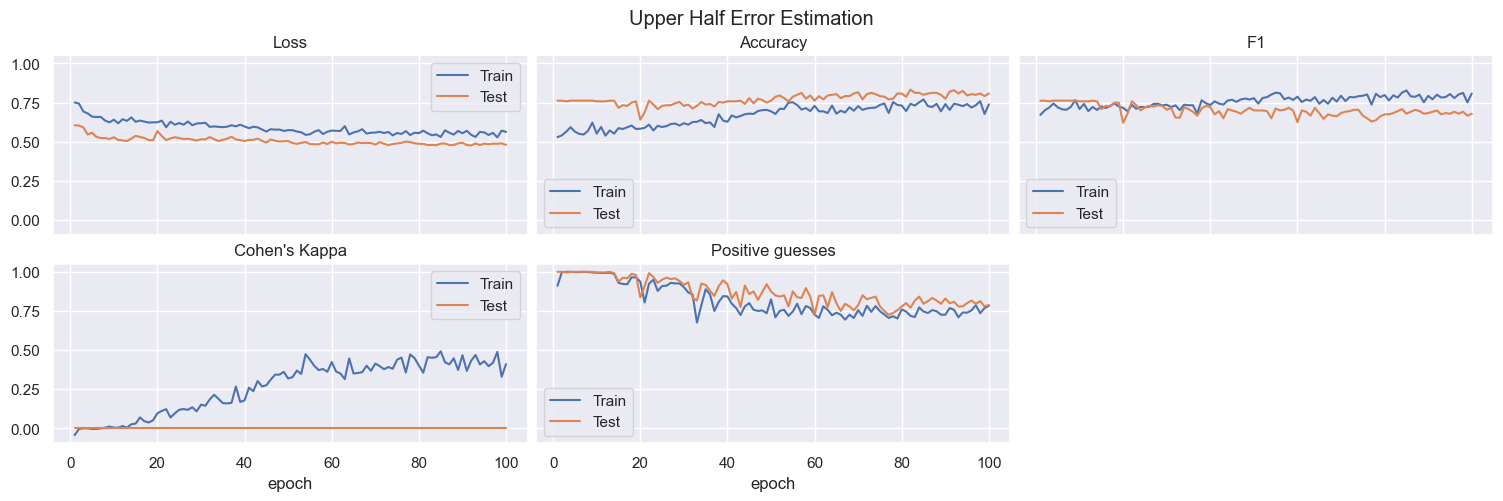

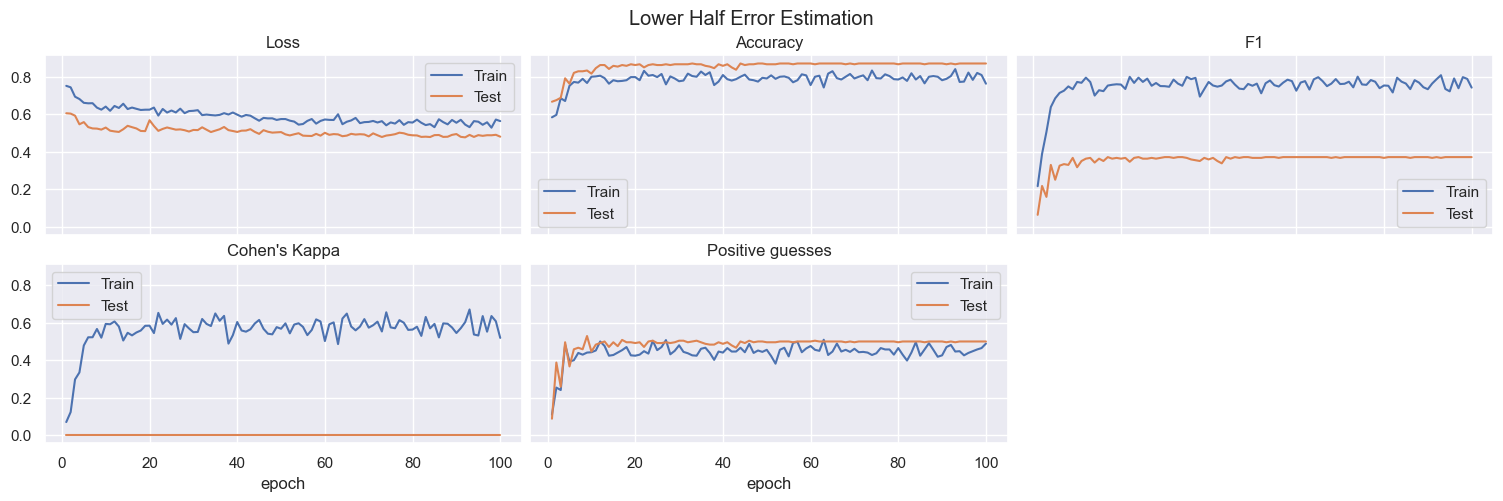

In [111]:
fig_uh, axs_uh = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=(15, 10))
fig_lh, axs_lh = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=(15, 10))

vals_lh_tr = df_model_train_hb[df_model_train_hb["joint"] == "Lower Half"][df_model_train_hb["train_test"] == "train"]
vals_lh_te = df_model_train_hb[df_model_train_hb["joint"] == "Lower Half"][df_model_train_hb["train_test"] == "test"]
vals_uh_tr = df_model_train_hb[df_model_train_hb["joint"] == "Upper Half"][df_model_train_hb["train_test"] == "train"]
vals_uh_te = df_model_train_hb[df_model_train_hb["joint"] == "Upper Half"][df_model_train_hb["train_test"] == "test"]

def plot(df, axs):
  df = df[["epoch", "loss", "accuracy", "f1", "cohens_kappa", "p/(p+n)", "Avg loss"]].groupby(["epoch"]).mean()
  
  df.plot(y="loss", figsize=(15, 5), title="Loss", ax=axs[0][0])
  df.plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1])
  df.plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2])
  df.plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0])
  df.plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1])

plot(vals_lh_tr, axs_lh)
plot(vals_lh_te, axs_lh)

for ax in axs_lh.flatten():
  ax.legend(["Train", "Test"])

fig_lh.delaxes(axs_lh[1][2])
fig_lh.suptitle("Lower Half Error Estimation")
fig_lh.tight_layout(pad=.5)
plt.savefig(result_dir / "hb/LowerBody_ErrorEstimation_uh.png", dpi=300, bbox_inches='tight')

plot(vals_uh_tr, axs_uh)
plot(vals_uh_te, axs_uh)

for ax in axs_uh.flatten():
  ax.legend(["Train", "Test"])

fig_uh.delaxes(axs_uh[1][2])
fig_uh.suptitle("Upper Half Error Estimation")

fig_uh.tight_layout(pad=.5)
plt.savefig(result_dir / "hb/UpperBody_HalfBodyErrorEstimation.png", dpi=300, bbox_inches='tight')
plt.show()

#### Body parts

In [113]:
df_model_train_bp = df_model_train[df_model_train["mode"] == Mode.BODY_PARTS]
df_model_train_bp["joint"] = df_model_train_bp["joint_id"].apply(lambda x: body_parts[x])

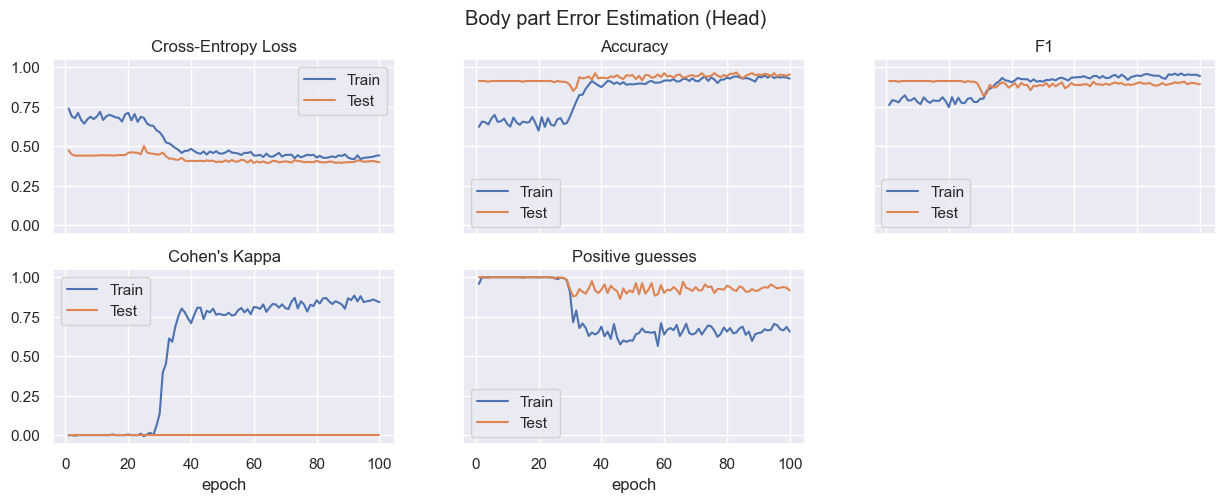

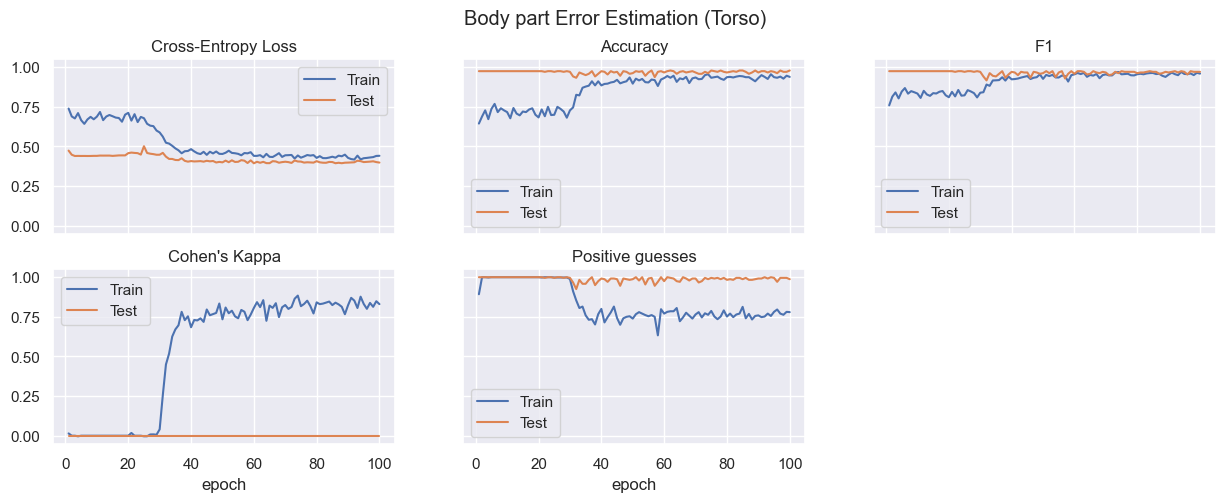

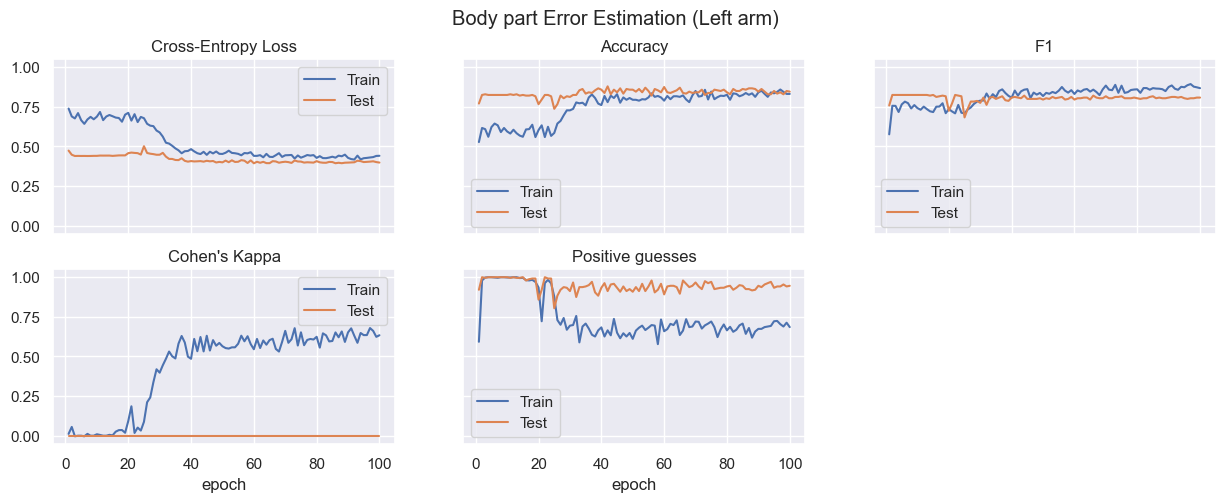

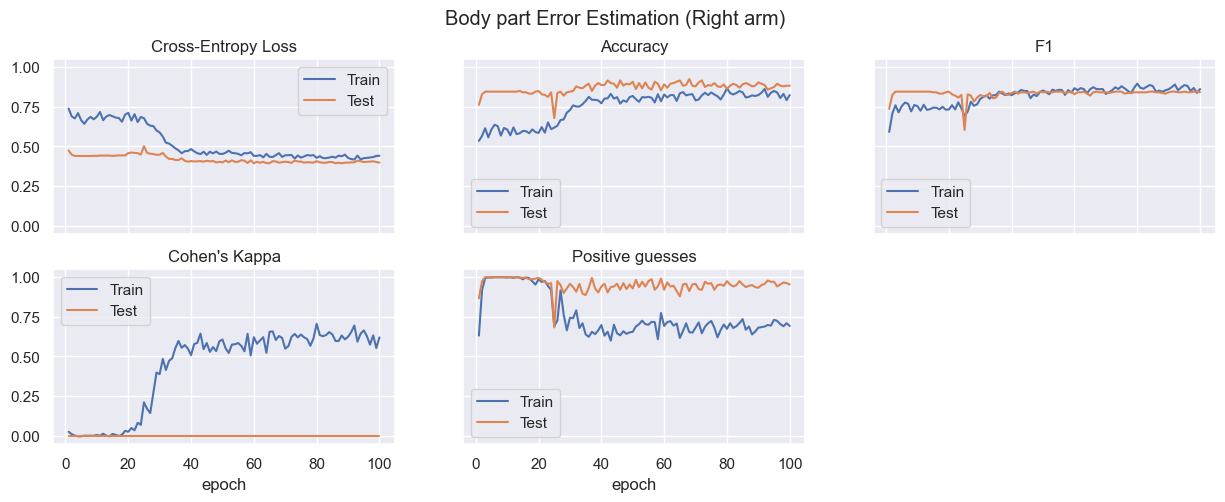

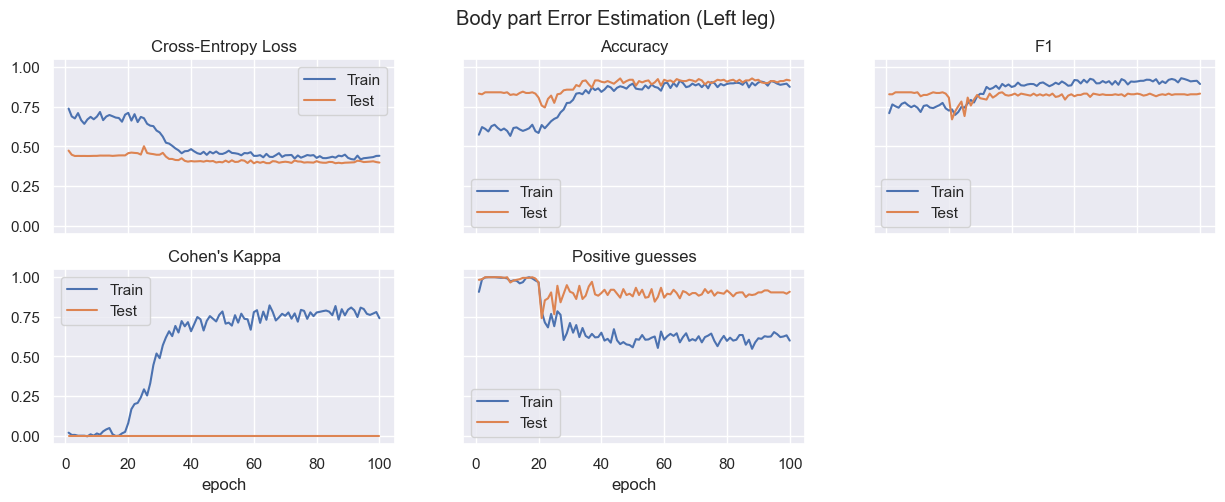

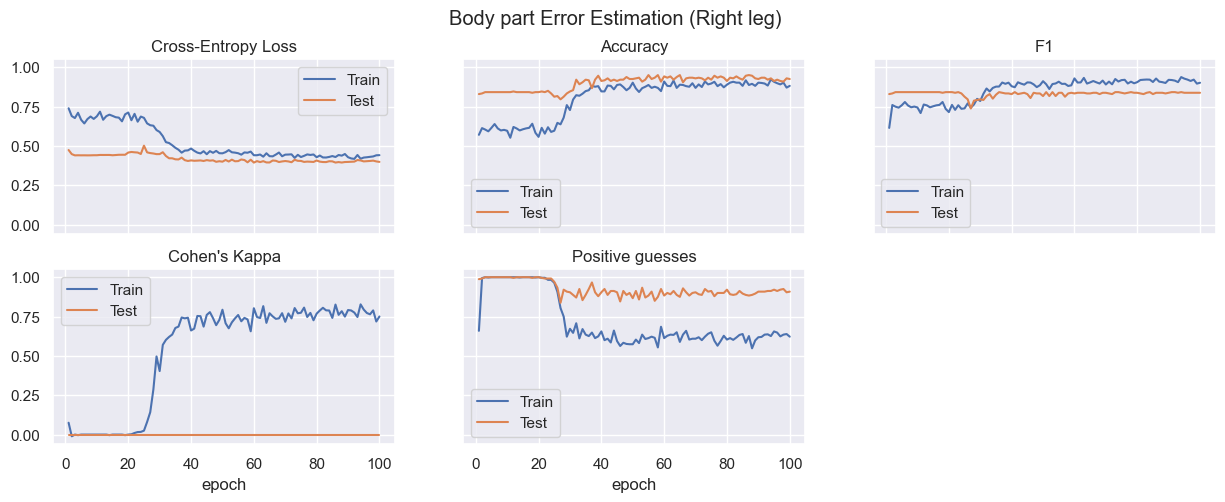

In [114]:

def plot(df, axs, body_part):
  df = df[["epoch", "loss", "accuracy", "f1", "cohens_kappa", "p/(p+n)", "Avg loss"]].groupby(["epoch"]).mean()
  
  df.plot(y="loss",         figsize=(15, 5), title="Cross-Entropy Loss", ax=axs[0][0], legend=False)
  df.plot(y="accuracy",     figsize=(15, 5), title="Accuracy", ax=axs[0][1], legend=False)
  df.plot(y="f1",           figsize=(15, 5), title="F1", ax=axs[0][2], legend=False)
  df.plot(y="cohens_kappa", figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0], legend=False)
  df.plot(y="p/(p+n)" ,     figsize=(15, 5), title="Positive guesses", ax=axs[1][1], legend=False)

for body_part in body_parts:
  fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 10))

  crit_1 = df_model_train_bp["joint"] == body_part
  crit_train = df_model_train_bp["train_test"] == "train"
  crit_test = df_model_train_bp["train_test"] == "test"
  crit = crit_1 & crit_train
  df_train = df_model_train_bp[crit]
  crit = crit_1 & crit_test
  df_test = df_model_train_bp[crit]

  plot(df_train, axs, body_part)
  plot(df_test, axs, body_part)
  fig.delaxes(axs[1][2])
  for ax in axs.flatten():
    ax.legend(["Train", "Test"])
    
  #fig.tight_layout(pad=.5)
  fig.suptitle(f"Body part Error Estimation ({body_part})")
  plt.savefig(result_dir / f"bp/{body_part}_ErrorEstimation.png", dpi=300, bbox_inches='tight')
plt.show()

#### Joints

In [115]:
df_model_train_jt = df_model_train[df_model_train["mode"] == Mode.JOINTS]
df_model_train_jt["joint"] = df_model_train_jt["joint_id"].apply(lambda x: joint_names[x])

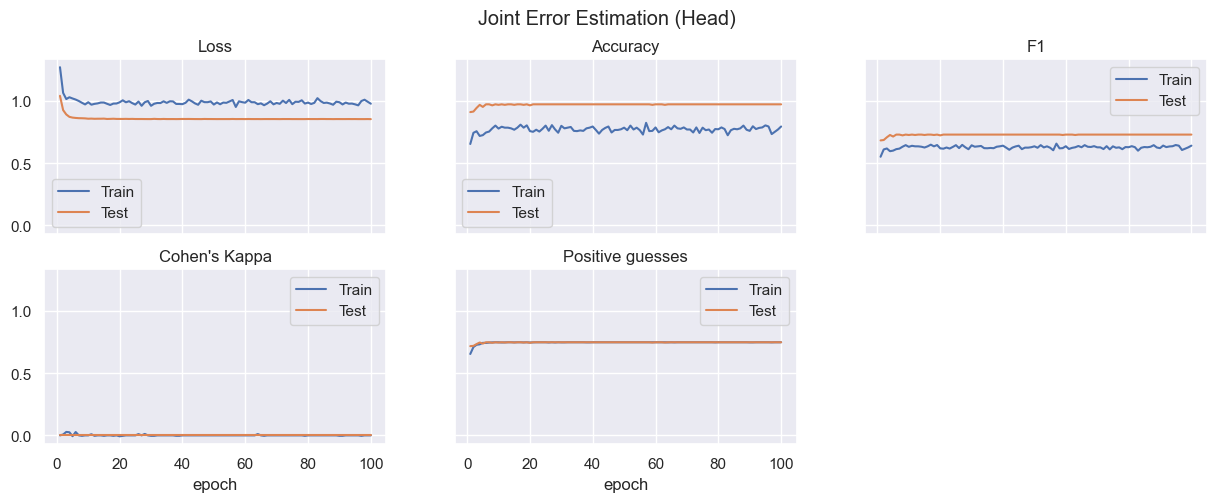

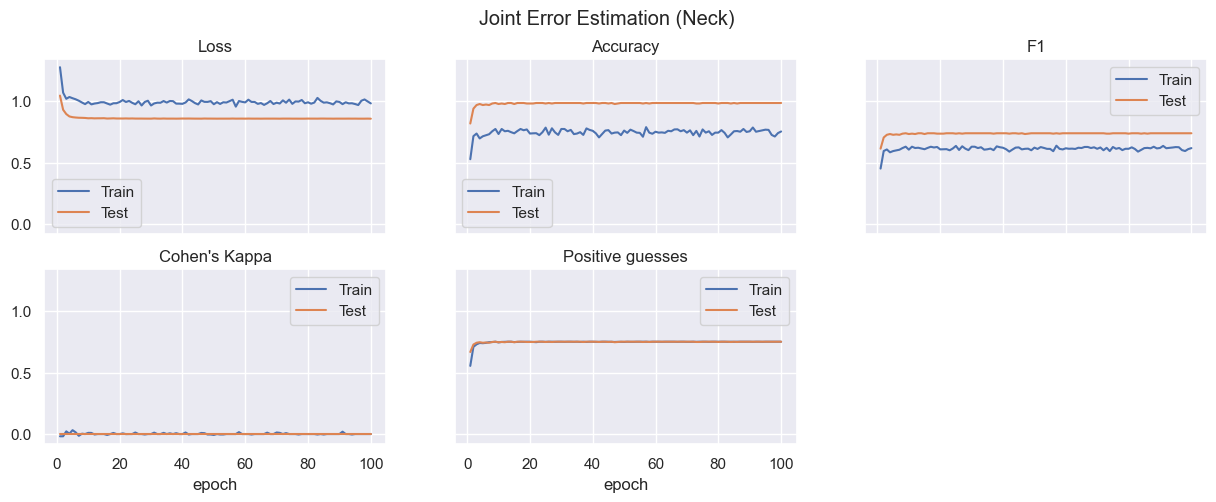

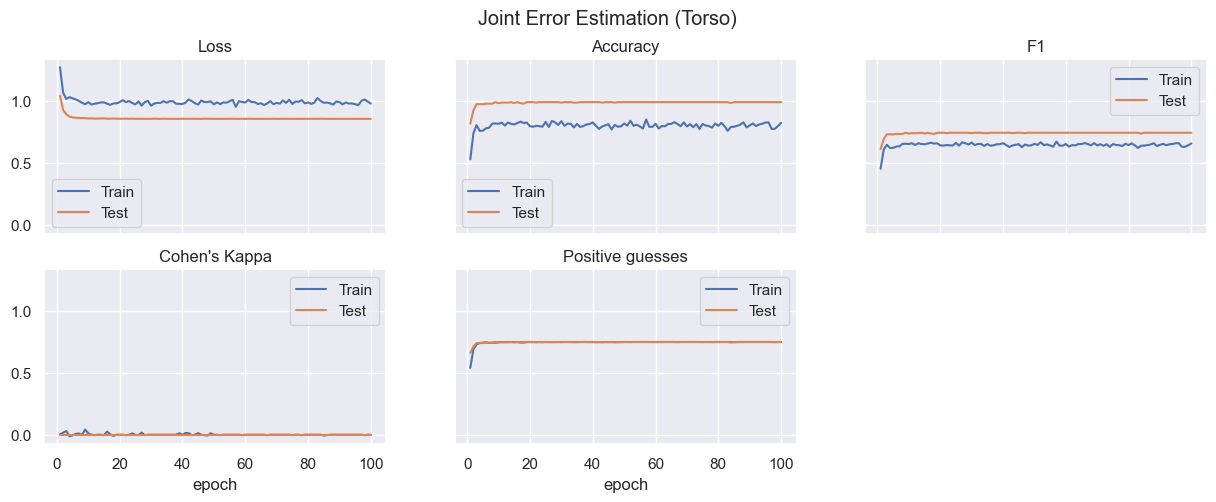

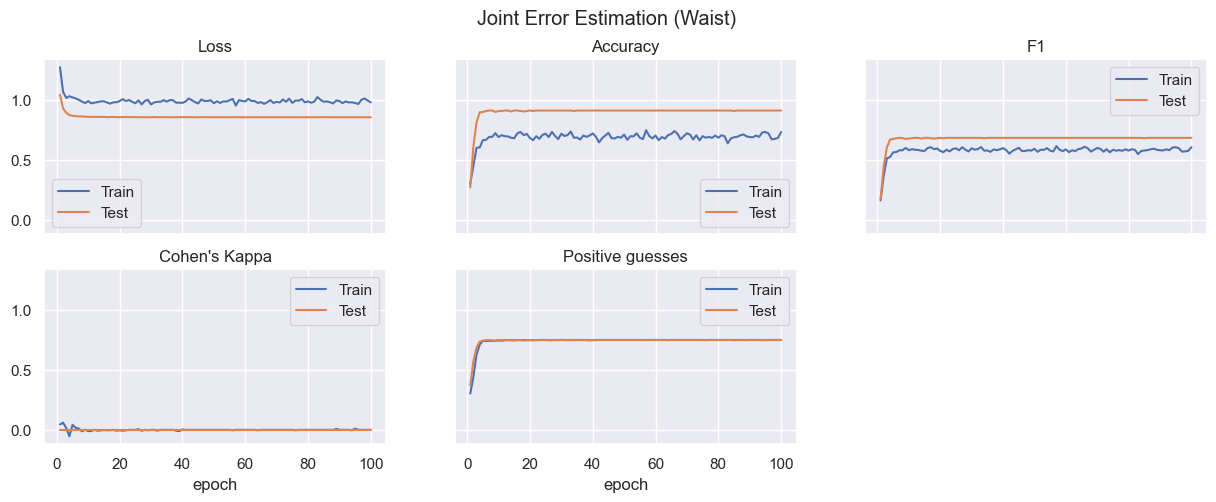

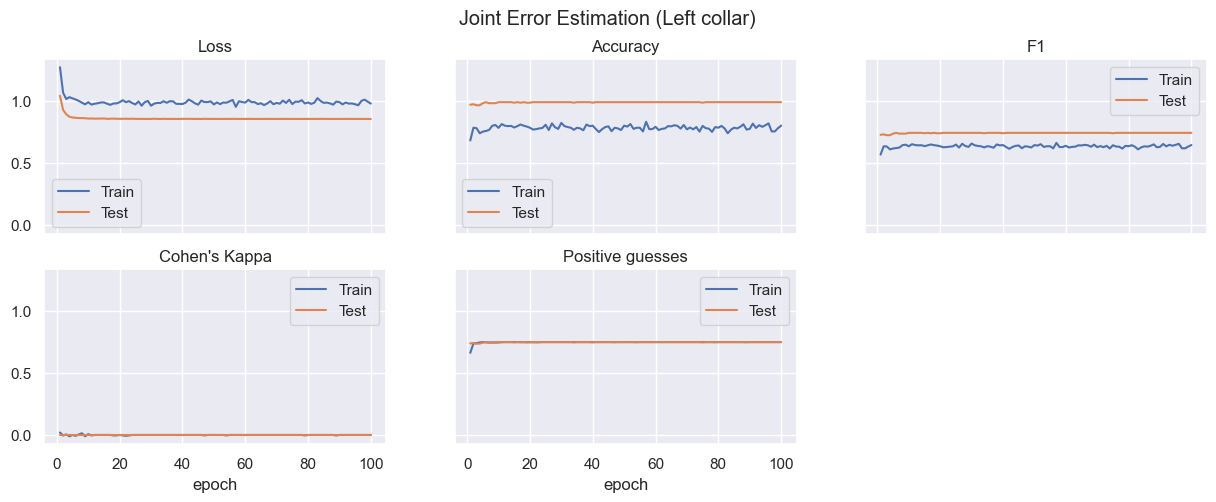

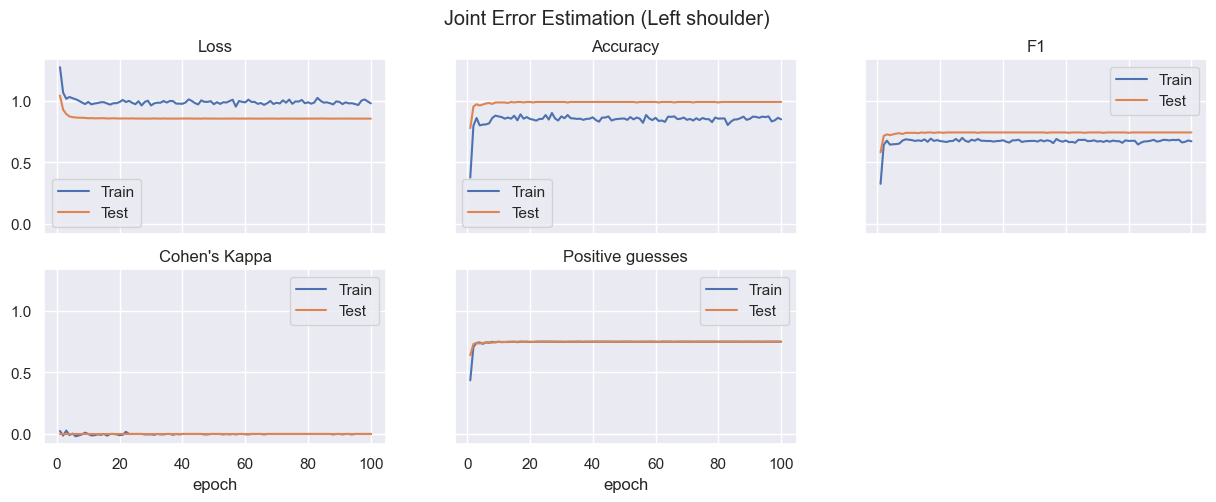

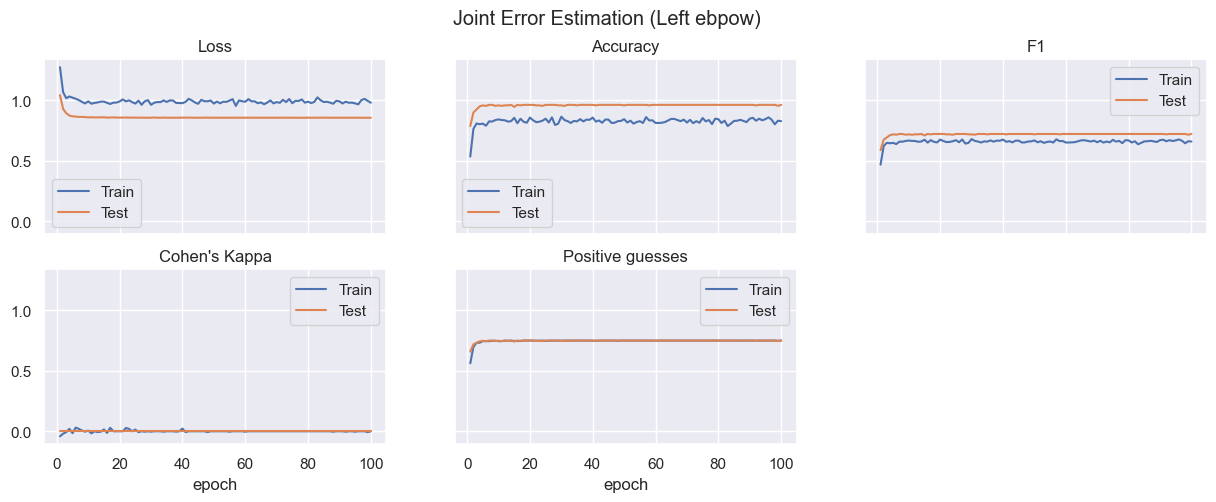

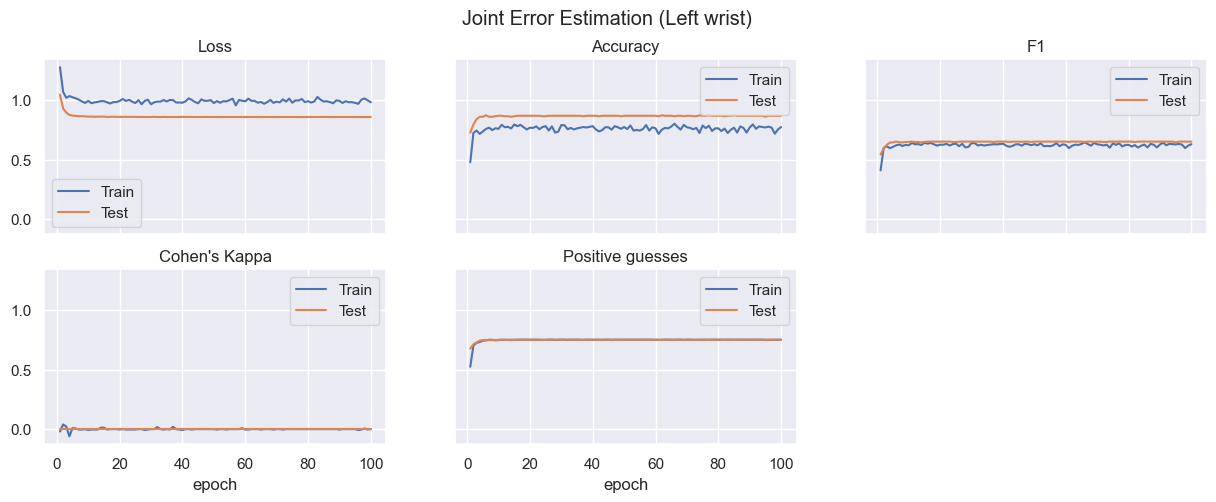

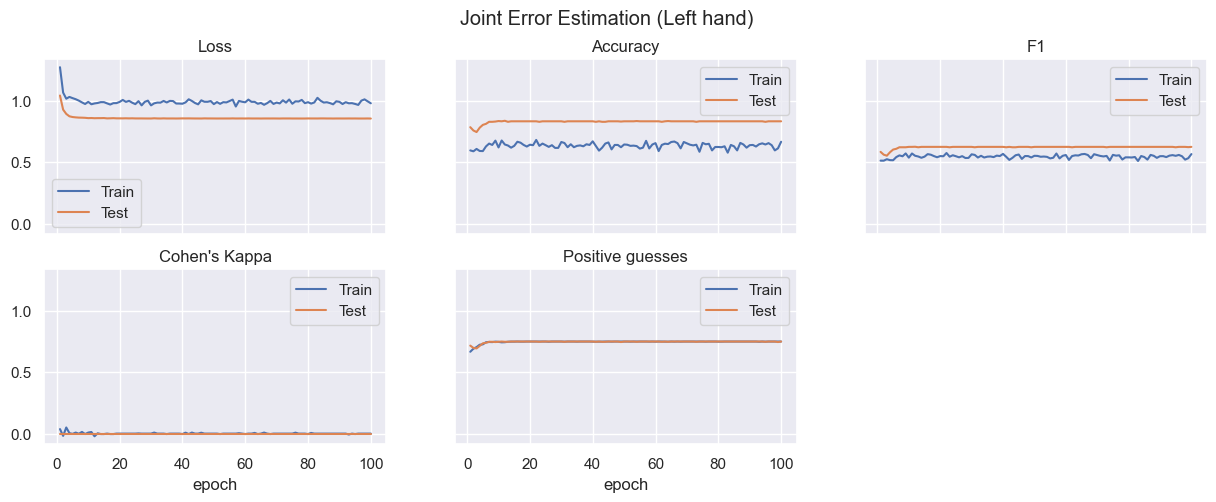

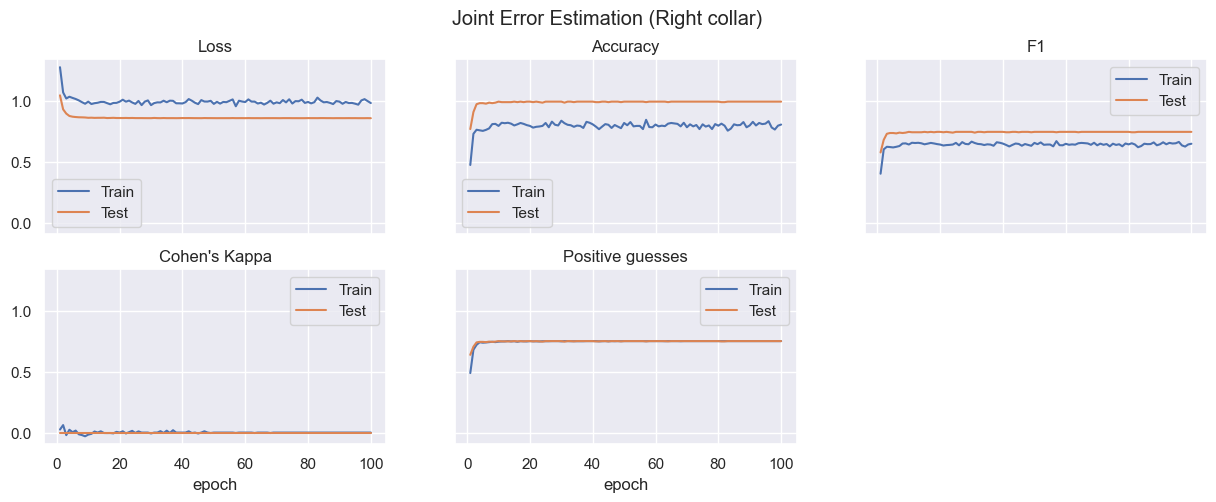

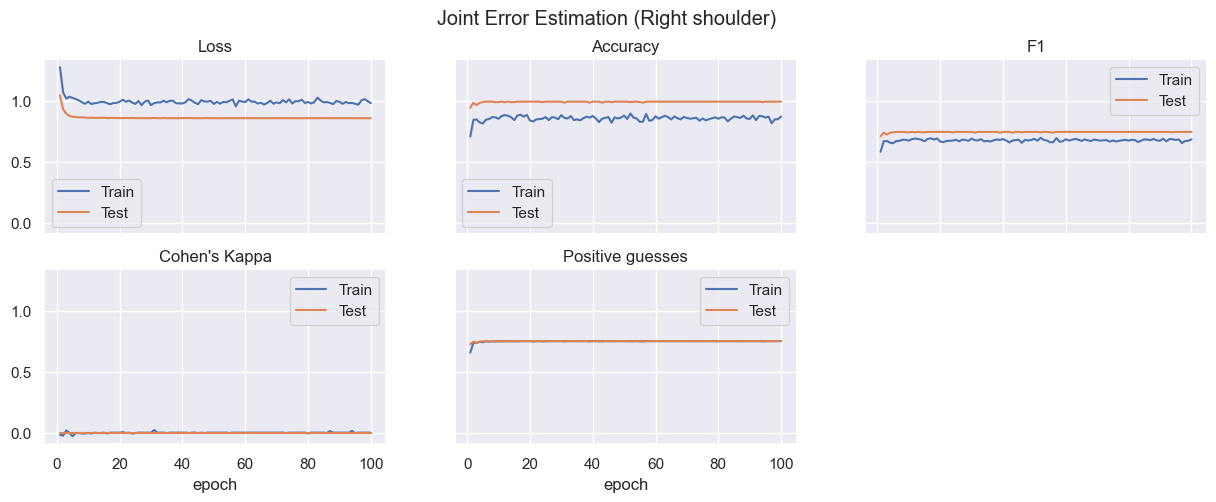

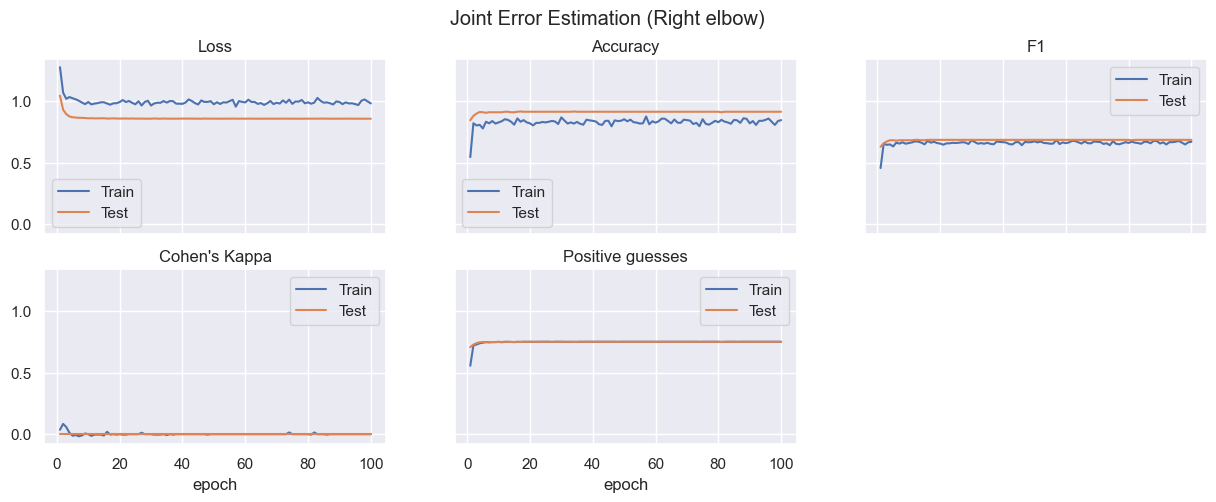

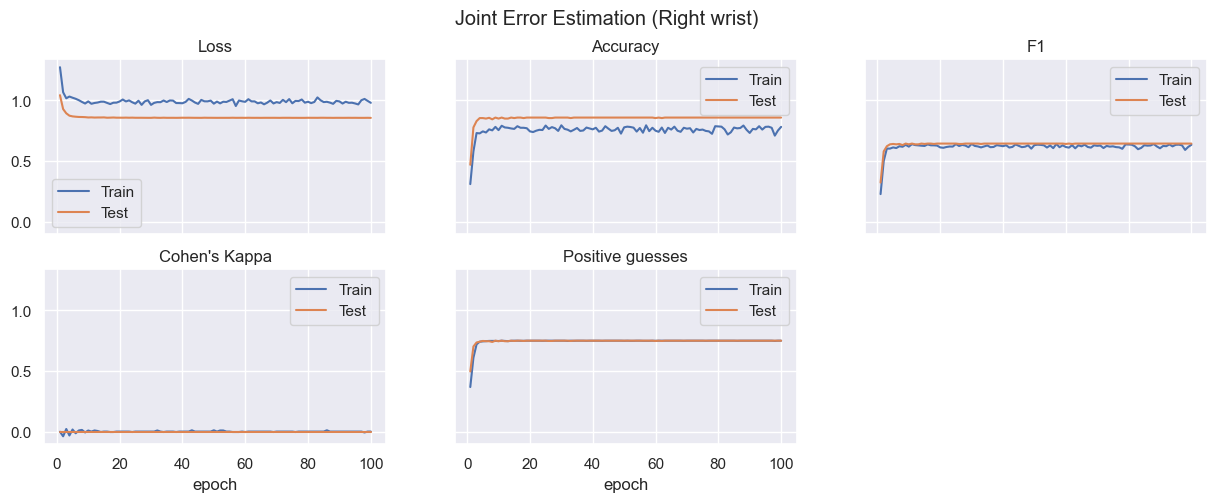

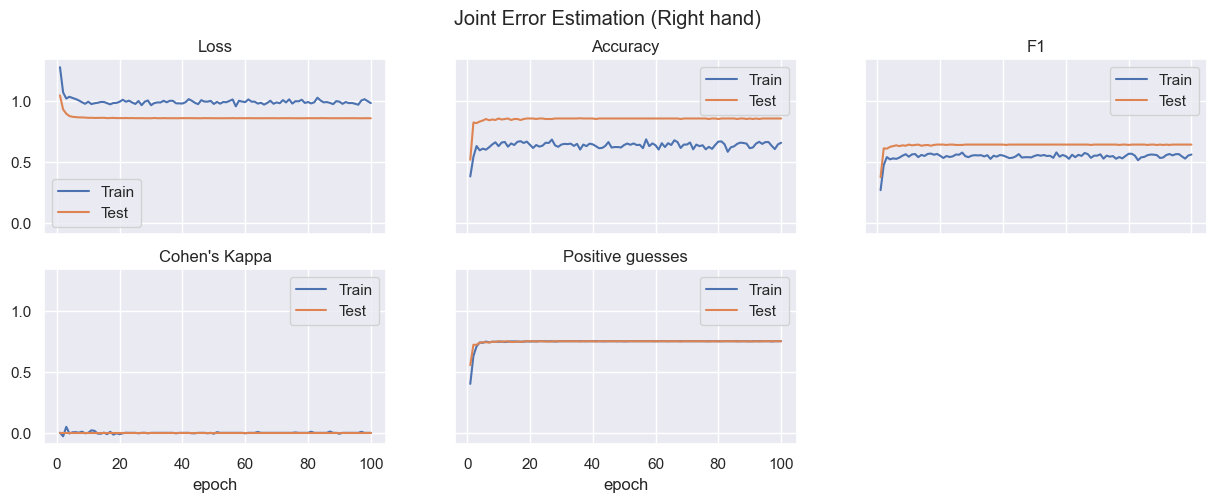

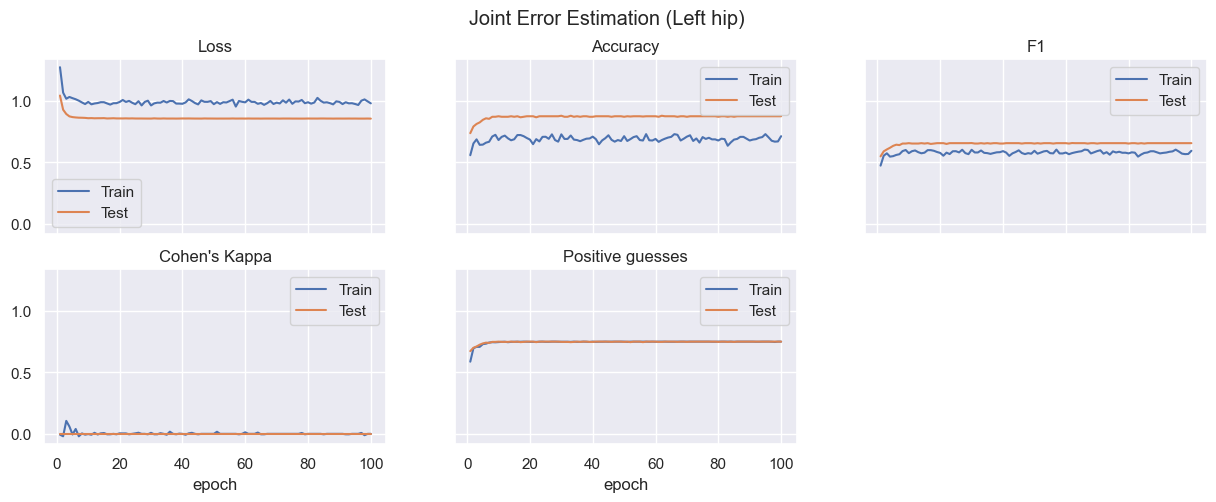

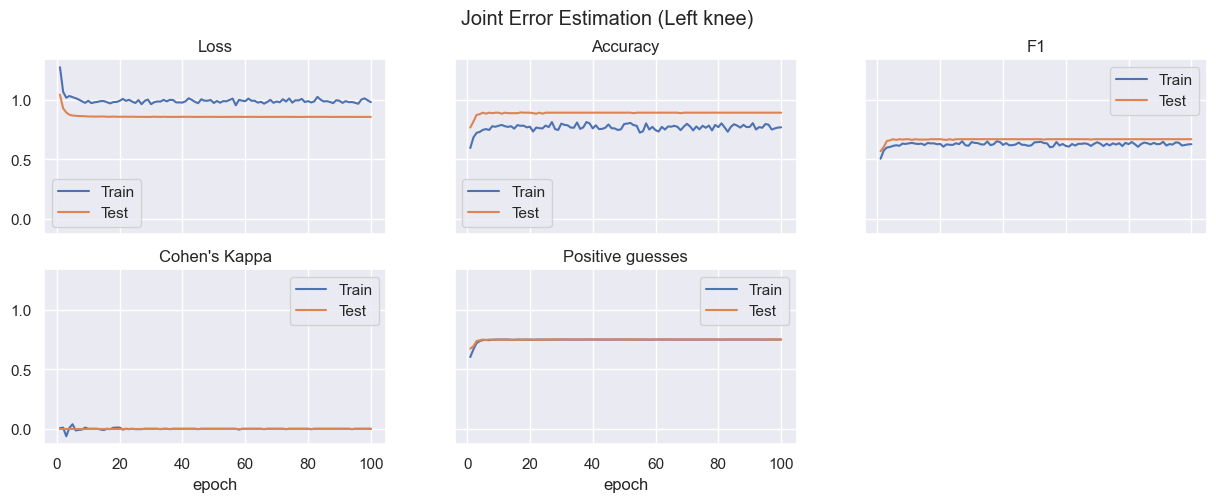

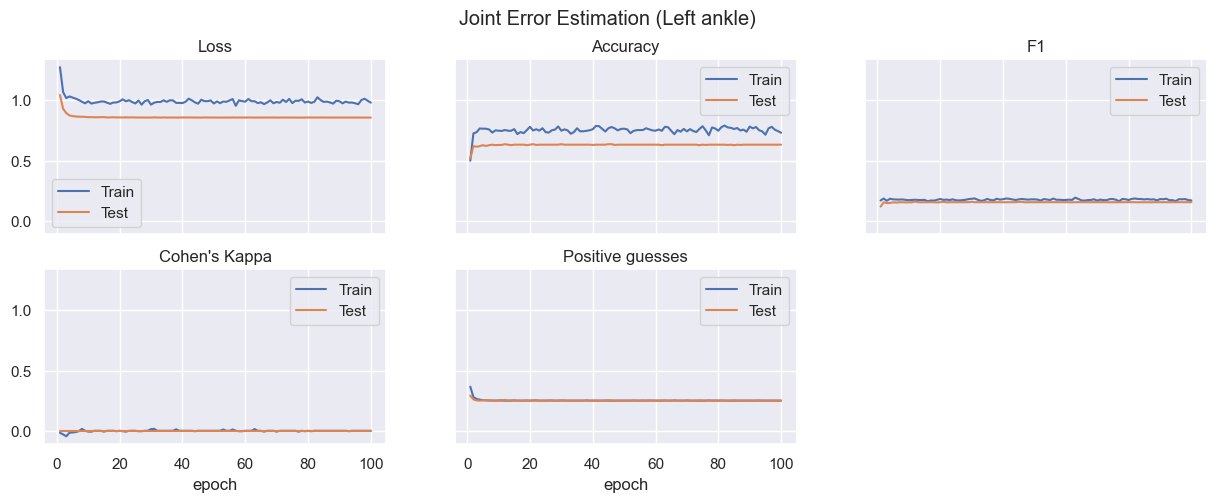

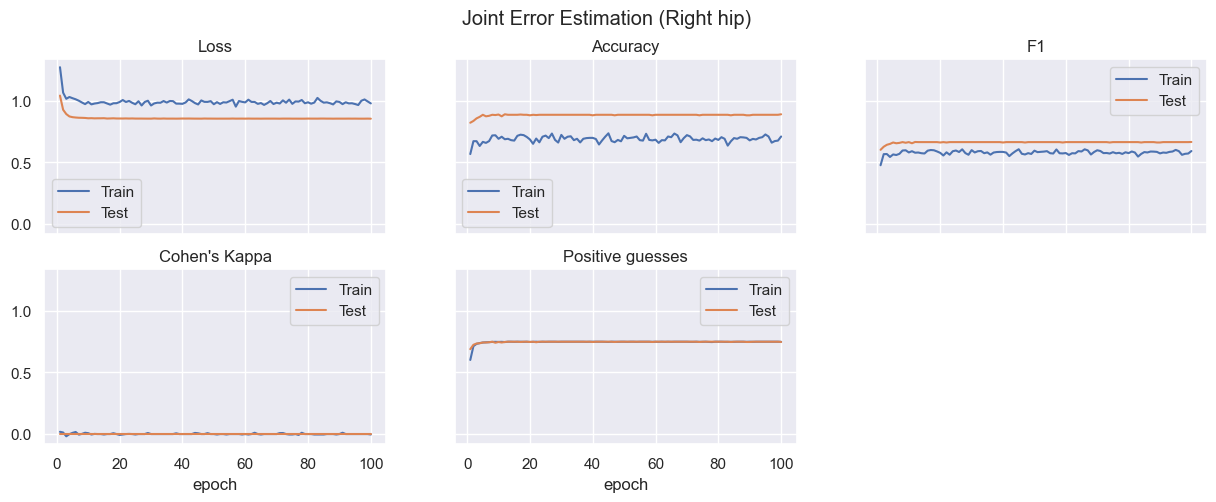

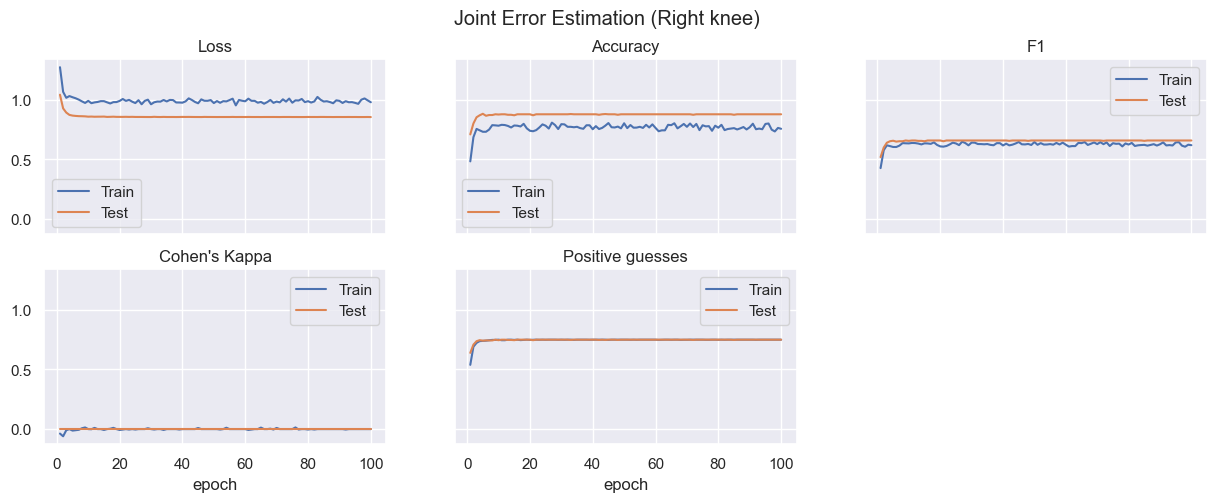

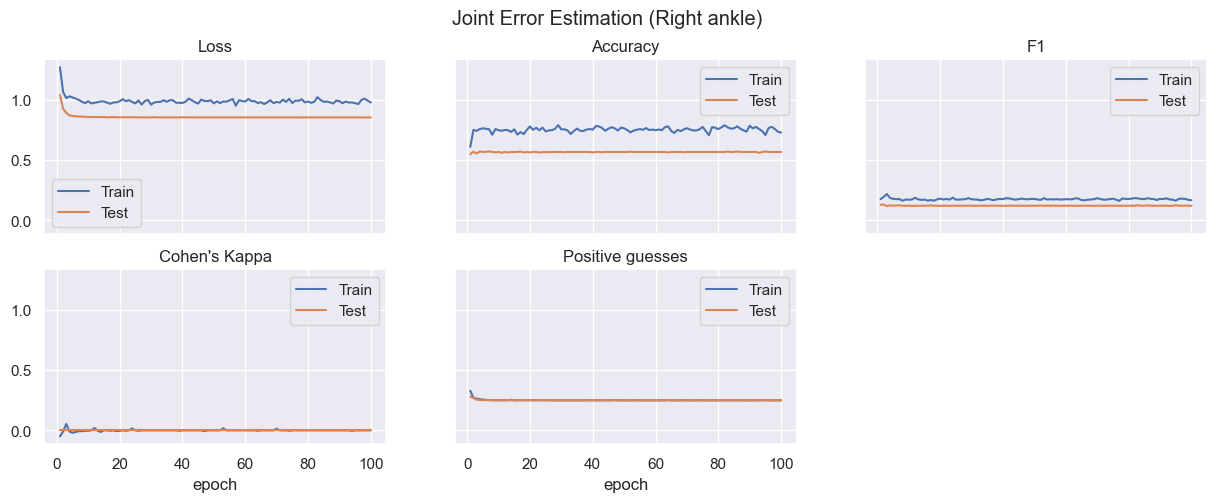

In [128]:
def plot(df, axs):
  df = df[["epoch", "loss", "accuracy", "f1", "cohens_kappa", "p/(p+n)", "Avg loss"]].groupby(["epoch"]).mean()
  
  df.plot(y="loss", figsize=(15, 5), title="Loss", ax=axs[0][0], legend=False)
  df.plot(y="accuracy" , figsize=(15, 5), title="Accuracy", ax=axs[0][1], legend=False)
  df.plot(y="f1" , figsize=(15, 5), title="F1", ax=axs[0][2], legend=False)
  df.plot(y="cohens_kappa" , figsize=(15, 5), title="Cohen's Kappa", ax=axs[1][0], legend=False)
  df.plot(y="p/(p+n)" , figsize=(15, 5), title="Positive guesses", ax=axs[1][1], legend=False)


for joint in joint_names:
  fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 10))

  crit = df_model_train_jt["joint"] == joint
  df_joint = df_model_train_jt[crit]
  
  df_train = df_joint[df_joint["train_test"] == "train"]
  df_test = df_joint[df_joint["train_test"] == "test"]

  plot(df_train, axs)
  plot(df_test, axs)
  fig.delaxes(axs[1][2])
  for ax in axs.flatten():
    ax.legend(["Train", "Test"])
    
  fig.suptitle(f"Joint Error Estimation ({joint})")
  plt.savefig(result_dir / f"jt/{joint}_ErrorEstimation.png", dpi=300, bbox_inches='tight')

plt.show()

### Test Evaluation

#### Full Body Evaluation

The evaluation of the whole body as an error boolean.

In [129]:
df_model_full_body = df_model[df_model["mode"] == Mode.FULL_BODY]
df_model_full_body_test = df_model_full_body[df_model_full_body["train_test"] == "test"][df_model_full_body["epoch"] == 100]

C:\Users\leona\AppData\Local\Temp\ipykernel_25680\3124289914.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_model_full_body_test = df_model_full_body[df_model_full_body["train_test"] == "test"][df_model_full_body["epoch"] == 100]


In [130]:
df_model_full_body_test[coi].groupby(["difficulty"]).mean().sort_values(by="difficulty", ascending=False)

,p/(p+n),accuracy,precision,recall,f1,cohens_kappa
difficulty,,,,,,
3,0.300000,0.900000,0.266667,0.266667,0.266667,0.0
2,0.600000,0.566667,0.400000,0.400000,0.400000,0.0
1,1.000000,0.933333,0.933333,0.933333,0.933333,0.0
0,0.966667,0.966667,0.966667,0.966667,0.966667,0.0


In [131]:
df_model_full_body_test[coi_tf_pn + ["difficulty"]].groupby(["difficulty"]).sum()

,tp,tn,fp,fn,p,n
difficulty,,,,,,
0,58.0,0.0,0.0,2.0,58.0,2.0
1,56.0,0.0,4.0,0.0,60.0,0.0
2,24.0,10.0,12.0,14.0,36.0,24.0
3,16.0,38.0,2.0,4.0,18.0,42.0


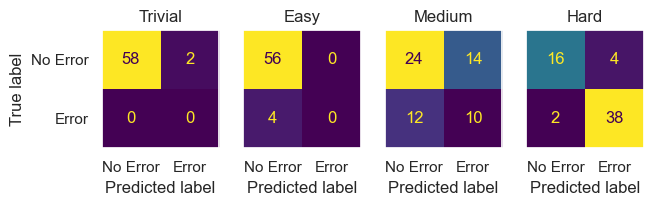

In [132]:
fig, axs = plt.subplots(1, 4, figsize=(7, 2.5), sharey=True)
difficulty_names = ["Trivial", "Easy", "Medium", "Hard"]
for difficulty in [0, 1, 2, 3]:
  gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_full_body_test[df_model_full_body_test["difficulty"] == difficulty]["gts"].values.tolist()]
  preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_full_body_test[df_model_full_body_test["difficulty"] == difficulty]["preds"].values.tolist()]
  cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
  disp.plot(ax=axs[difficulty], colorbar=False)
  axs[difficulty].set_title(difficulty_names[difficulty])
  axs[difficulty].grid(False)
  if difficulty != 0:
    axs[difficulty].set_ylabel("")


plt.savefig(result_dir / "confusion/full_difficulty.png", dpi=300, bbox_inches='tight')
plt.show()

In [166]:
def single_confusion(df, result_dir, ps_name, file_name):
  fig, axs = plt.subplots(1, 1, figsize=(7, 2.5), sharey=True)

  gts = ["No Error" if x[0] == 0 else "Error" for x in df[df["difficulty"] == difficulty]["gts"].values.tolist()]
  preds = ["No Error" if x[0] == 0 else "Error" for x in df[df["difficulty"] == difficulty]["preds"].values.tolist()]
  cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
  disp.plot(ax=axs, colorbar=False)

  axs.grid(False)

  fig.suptitle(f"{ps_name}\nConfusion Matrix")
  plt.tight_layout()
  plt.savefig(result_dir / f"confusion/{file_name}", dpi=300, bbox_inches='tight')

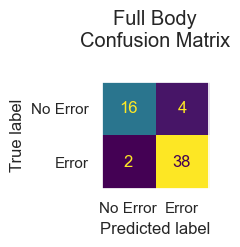

In [167]:
single_confusion(df_model_full_body_test, result_dir,"Full Body", "full_together.png")
plt.show()

#### Half Body Evaluation

The evaluation of the body split into two parts (upper and lower body), each as an error boolean.

In [134]:
# Split the data

df_model_half_body = df_model[df_model["mode"] == Mode.HALF_BODY]
df_model_half_body["joint_names"] = df_model_half_body["joint_id"].apply(lambda x: body_halves[x])
df_model_half_body_test = df_model_half_body[df_model_half_body["train_test"] == "test"][df_model_half_body["epoch"] == 100]

C:\Users\leona\AppData\Local\Temp\ipykernel_25680\3873470278.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_model_half_body_test = df_model_half_body[df_model_half_body["train_test"] == "test"][df_model_half_body["epoch"] == 100]


In [135]:
df_model_half_body_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall        f1  \
joint_names difficulty                                                      
Lower Half  0           1.000000  0.533333   0.533333  0.533333  0.533333   
            1           1.000000  0.950000   0.950000  0.950000  0.950000   
            2           0.000000  1.000000   0.000000  0.000000  0.000000   
            3           0.000000  1.000000   0.000000  0.000000  0.000000   
Upper Half  0           0.966667  0.966667   0.966667  0.966667  0.966667   
            1           0.850000  0.750000   0.700000  0.700000  0.700000   
            2           0.850000  0.750000   0.700000  0.700000  0.700000   
            3           0.483333  0.766667   0.350000  0.350000  0.350000   

                        cohens_kappa  
joint_names difficulty                
Lower Half  0                    0.0  
            1                    0.0  
            2                    NaN  
            3                    NaN  
Upper Half  0                    0.0  
            1                    0.0  
            2                    0.0  
            3                    0.0

In [136]:
df_model_half_body_test[coi_tf_pn + ["joint_names", "difficulty"]].groupby(["joint_names", "difficulty"]).sum()

tp    tn    fp   fn     p     n
joint_names difficulty                                   
Lower Half  0           32.0   0.0  28.0  0.0  60.0   0.0
            1           57.0   0.0   3.0  0.0  60.0   0.0
            2            0.0  60.0   0.0  0.0   0.0  60.0
            3            0.0  60.0   0.0  0.0   0.0  60.0
Upper Half  0           58.0   0.0   0.0  2.0  58.0   2.0
            1           42.0   3.0   9.0  6.0  51.0   9.0
            2           42.0   3.0   9.0  6.0  51.0   9.0
            3           21.0  25.0   8.0  6.0  29.0  31.0

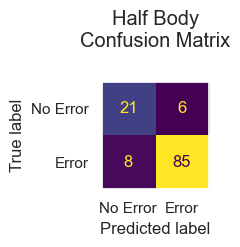

In [168]:
single_confusion(df_model_half_body_test, result_dir, "Half Body", "half_together.png")
plt.show()

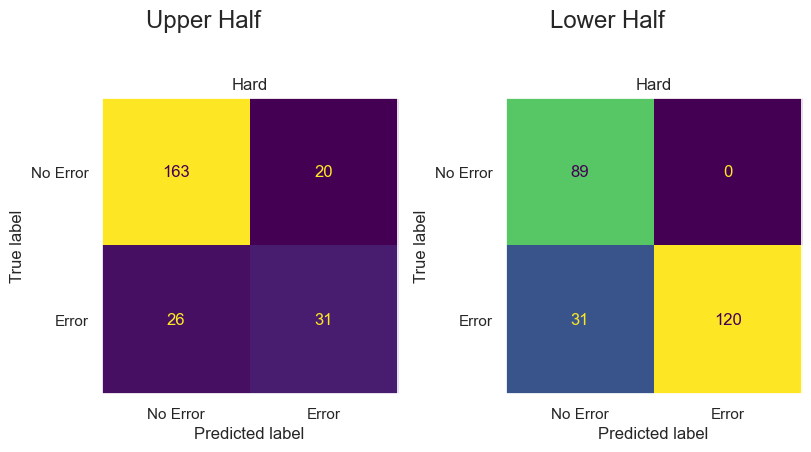

In [163]:
df = df_model_half_body_test
areas = body_halves

rows = 1
cols = 2
assert len(areas) == rows * cols

figure = plt.figure(layout='constrained', figsize=(4 * cols, 4.5 * rows))
subfigs = figure.subfigures(rows, cols)

for i, area in enumerate(areas):
  axs = subfigs.flatten()[i].subplots(1, 1)
  subfigs.flatten()[i].suptitle(area, fontsize='x-large')

  crit = df["joint_names"] == area
  gts = ["No Error" if x[0] == 0 else "Error" for x in df[crit]["gts"].values.tolist()]
  preds = ["No Error" if x[0] == 0 else "Error" for x in df[crit]["preds"].values.tolist()]

  cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
  disp.plot(ax=axs, colorbar=False)

  axs.grid(False)
  axs.set_title(difficulty_names[difficulty])

#plt.tight_layout()
plt.savefig(result_dir / "confusion/half_halves.png", dpi=300, bbox_inches='tight')
plt.show()

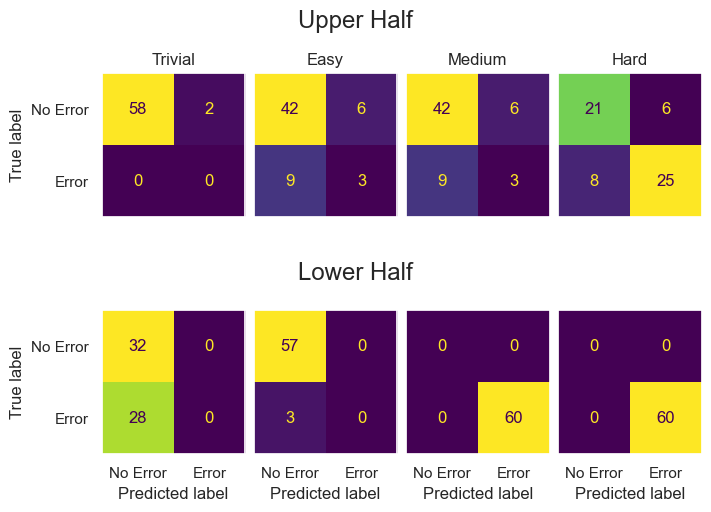

In [139]:
figure = plt.figure(layout='constrained', figsize=(7, 2.5 * len(body_halves)))
subfigs = figure.subfigures(2, 1)

difficulty_names = ["Trivial", "Easy", "Medium", "Hard"]
for i, half in enumerate(body_halves):
  axs = subfigs[i].subplots(1, 4, sharey=True)
  subfigs[i].suptitle(half, fontsize='x-large')
  for difficulty in [0, 1, 2, 3]:  
    crit_1 = df_model_half_body_test["difficulty"] == difficulty
    crit_2 = df_model_half_body_test["joint_names"] == half
    crit = crit_1 & crit_2
    gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_half_body_test[crit]["gts"].values.tolist()]
    preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_half_body_test[crit]["preds"].values.tolist()]

    cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
    disp.plot(ax=axs[difficulty], colorbar=False)

    axs[difficulty].grid(False)
    if i == 0:
      axs[difficulty].set_title(difficulty_names[difficulty])
    if i < len(body_halves) - 1:
      axs[difficulty].set_xlabel("") 
      axs[difficulty].set_xticks([]) 
    if difficulty != 0:
      axs[difficulty].set_ylabel("")

#plt.tight_layout()
plt.savefig(result_dir / "confusion/half_difficulty.png", dpi=300, bbox_inches='tight')
plt.show()

#### Body part Evaluation

The evaluation of the body split into body_parts (Head, Torso, Left and Right Arm, and Left and Right Leg), each as an error boolean.

In [140]:
# Split the data

df_model_body_parts = df_model[df_model["mode"] == Mode.BODY_PARTS]
df_model_body_parts["joint_names"] = df_model_body_parts["joint_id"].apply(lambda x: body_parts[x])
df_model_body_parts_test = df_model_body_parts[df_model_body_parts["train_test"] == "test"][df_model_body_parts["epoch"] == 100]

C:\Users\leona\AppData\Local\Temp\ipykernel_25680\2333654123.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_model_body_parts_test = df_model_body_parts[df_model_body_parts["train_test"] == "test"][df_model_body_parts["epoch"] == 100]


In [141]:
df_model_body_parts_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall        f1  \
joint_names difficulty                                                      
Head        0           1.000000  1.000000   1.000000  1.000000  1.000000   
            1           1.000000  1.000000   1.000000  1.000000  1.000000   
            2           1.000000  0.983333   0.983333  0.983333  0.983333   
            3           0.666667  0.833333   0.583333  0.583333  0.583333   
Left arm    0           1.000000  1.000000   1.000000  1.000000  1.000000   
            1           1.000000  0.850000   0.850000  0.850000  0.850000   
            2           1.000000  0.900000   0.900000  0.900000  0.900000   
            3           0.783333  0.633333   0.483333  0.483333  0.483333   
Left leg    0           1.000000  1.000000   1.000000  1.000000  1.000000   
            1           1.000000  1.000000   1.000000  1.000000  1.000000   
            2           1.000000  0.883333   0.883333  0.883333  0.883333   
            3           0.633333  0.783333   0.450000  0.450000  0.450000   
Right arm   0           1.000000  1.000000   1.000000  1.000000  1.000000   
            1           1.000000  0.933333   0.933333  0.933333  0.933333   
            2           1.000000  0.883333   0.883333  0.883333  0.883333   
            3           0.816667  0.716667   0.550000  0.550000  0.550000   
Right leg   0           1.000000  1.000000   1.000000  1.000000  1.000000   
            1           1.000000  1.000000   1.000000  1.000000  1.000000   
            2           1.000000  0.916667   0.916667  0.916667  0.916667   
            3           0.633333  0.783333   0.433333  0.433333  0.433333   
Torso       0           1.000000  1.000000   1.000000  1.000000  1.000000   
            1           1.000000  1.000000   1.000000  1.000000  1.000000   
            2           1.000000  0.983333   0.983333  0.983333  0.983333   
            3           0.950000  0.933333   0.900000  0.900000  0.900000   

                        cohens_kappa  
joint_names difficulty                
Head        0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Left arm    0                    NaN  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Left leg    0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Right arm   0                    NaN  
            1                    0.0  
            2                    0.0  
            3                    0.0  
Right leg   0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Torso       0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0

In [142]:
df_model_body_parts_test[coi_tf_pn + ["joint_names", "difficulty"]].groupby(["joint_names", "difficulty"]).sum()

tp    tn    fp   fn     p     n
joint_names difficulty                                   
Head        0           60.0   0.0   0.0  0.0  60.0   0.0
            1           60.0   0.0   0.0  0.0  60.0   0.0
            2           59.0   0.0   1.0  0.0  60.0   0.0
            3           35.0  15.0   5.0  5.0  40.0  20.0
Left arm    0           60.0   0.0   0.0  0.0  60.0   0.0
            1           51.0   0.0   9.0  0.0  60.0   0.0
            2           54.0   0.0   6.0  0.0  60.0   0.0
            3           29.0   9.0  18.0  4.0  47.0  13.0
Left leg    0           60.0   0.0   0.0  0.0  60.0   0.0
            1           60.0   0.0   0.0  0.0  60.0   0.0
            2           53.0   0.0   7.0  0.0  60.0   0.0
            3           27.0  20.0  11.0  2.0  38.0  22.0
Right arm   0           60.0   0.0   0.0  0.0  60.0   0.0
            1           56.0   0.0   4.0  0.0  60.0   0.0
            2           53.0   0.0   7.0  0.0  60.0   0.0
            3           33.0  10.0  16.0  1.0  49.0  11.0
Right leg   0           60.0   0.0   0.0  0.0  60.0   0.0
            1           60.0   0.0   0.0  0.0  60.0   0.0
            2           55.0   0.0   5.0  0.0  60.0   0.0
            3           26.0  21.0  12.0  1.0  38.0  22.0
Torso       0           60.0   0.0   0.0  0.0  60.0   0.0
            1           60.0   0.0   0.0  0.0  60.0   0.0
            2           59.0   0.0   1.0  0.0  60.0   0.0
            3           54.0   2.0   3.0  1.0  57.0   3.0

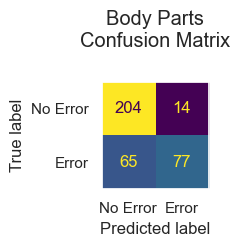

In [169]:
single_confusion(df_model_body_parts_test, result_dir, "Body Parts", "body_parts_together.png")
plt.show()

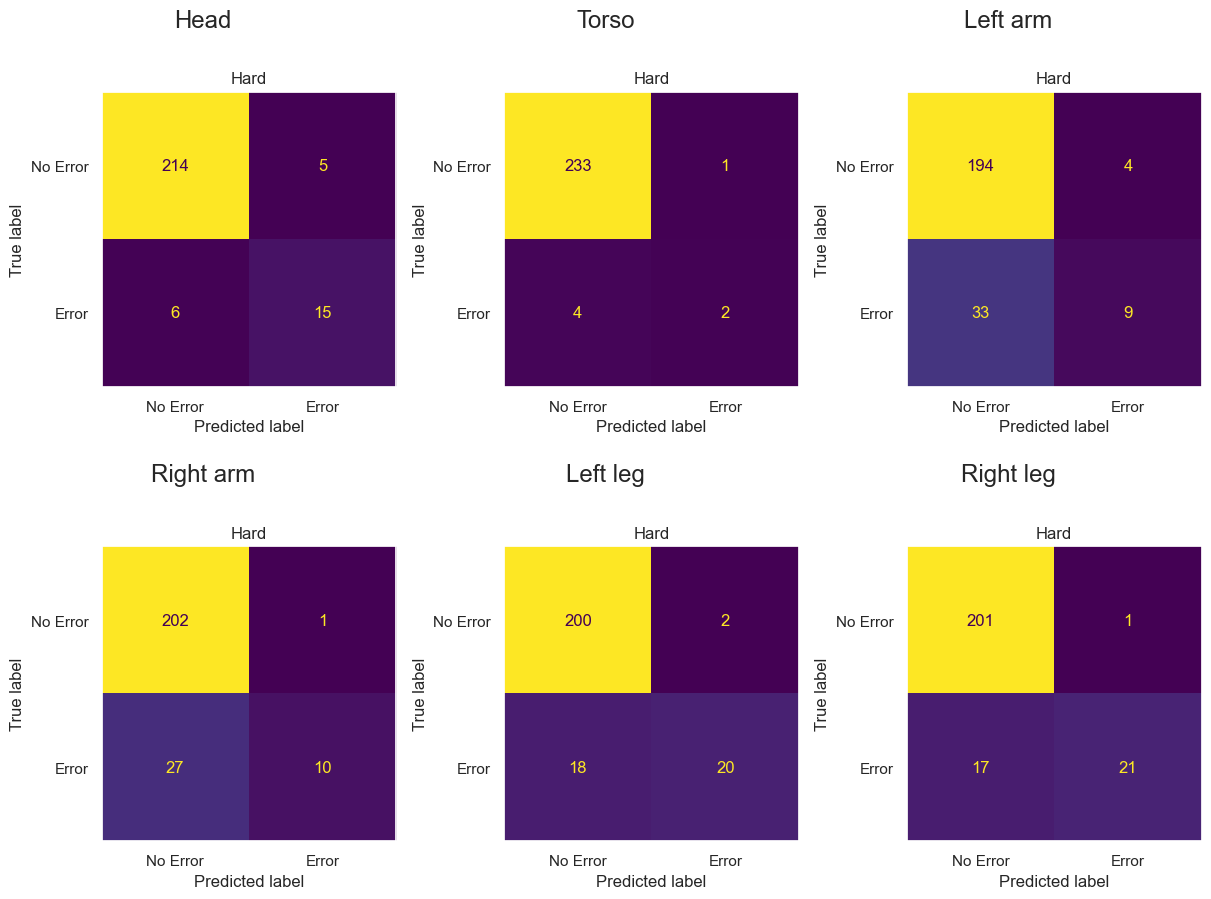

In [144]:
rows = 2
cols = 3

figure = plt.figure(layout='constrained', figsize=(4 * cols, 4.5 * rows))
subfigs = figure.subfigures(rows, cols)

for i, body_part in enumerate(body_parts):
  axs = subfigs.flatten()[i].subplots(1, 1)
  subfigs.flatten()[i].suptitle(body_part, fontsize='x-large')

  crit = df_model_body_parts_test["joint_names"] == body_part
  gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_body_parts_test[crit]["gts"].values.tolist()]
  preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_body_parts_test[crit]["preds"].values.tolist()]

  cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
  disp.plot(ax=axs, colorbar=False)

  axs.grid(False)
  axs.set_title(difficulty_names[difficulty])

#plt.tight_layout()
# plt.savefig(result_dir / "confusion/halves.png", dpi=300, bbox_inches='tight')
plt.show()

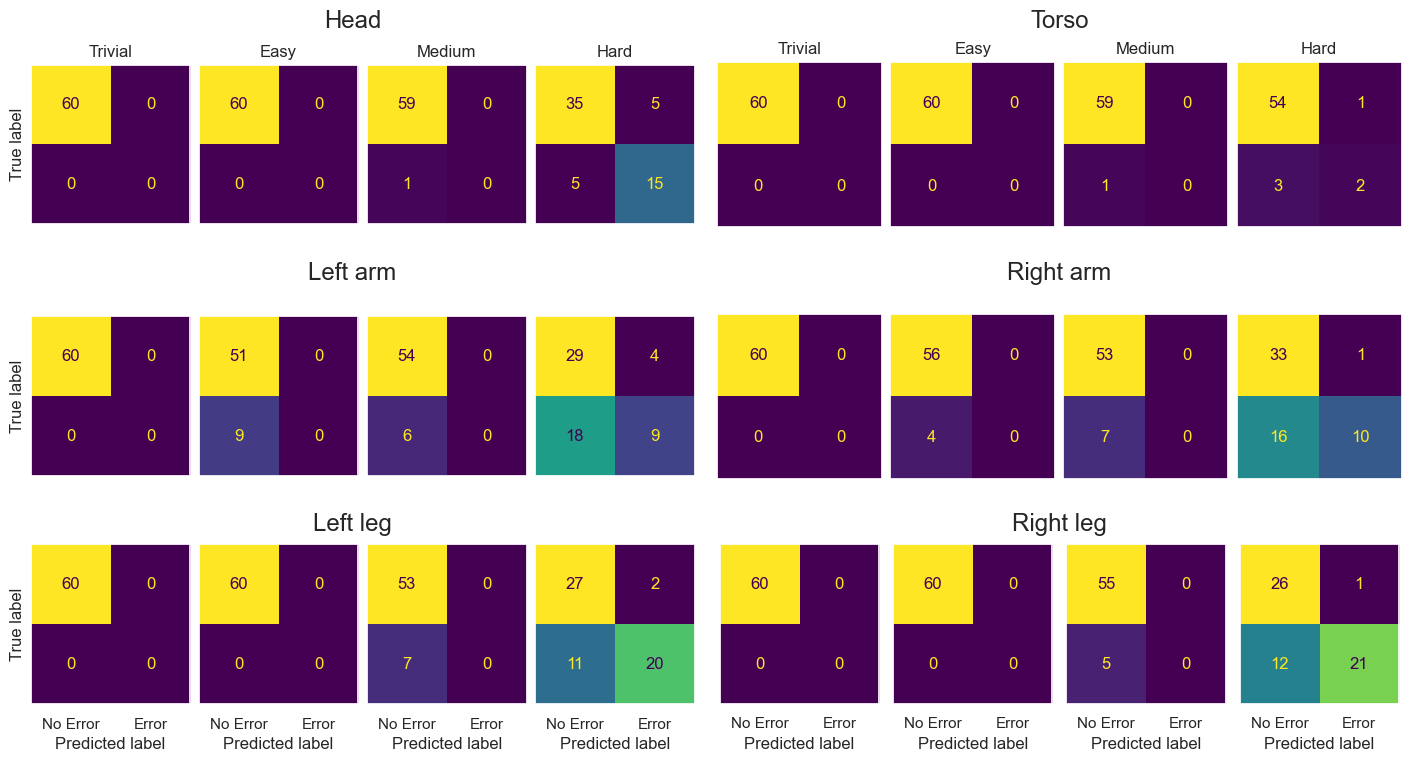

In [145]:
rows = 3
cols = 2
assert rows * cols == len(body_parts)

figure = plt.figure(layout='constrained', figsize=(7 * cols, 2.5 * rows))
subfigs = figure.subfigures(nrows=rows, ncols=cols)

difficulty_names = ["Trivial", "Easy", "Medium", "Hard"]
for i, body_part in enumerate(body_parts):
  axs = subfigs.flatten()[i].subplots(1, 4, sharey=True)
  subfigs.flatten()[i].suptitle(body_part, fontsize='x-large')
  for difficulty in [0, 1, 2, 3]:  
    crit_1 = df_model_body_parts_test["difficulty"] == difficulty
    crit_2 = df_model_body_parts_test["joint_names"] == body_part
    crit = crit_1 & crit_2
    gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_body_parts_test[crit]["gts"].values.tolist()]
    preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_body_parts_test[crit]["preds"].values.tolist()]

    cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
    disp.plot(ax=axs[difficulty], colorbar=False)

    axs[difficulty].grid(False)
    if i == 0 or i == 1:
      axs[difficulty].set_title(difficulty_names[difficulty])
    if i < len(body_parts) - 2:
      axs[difficulty].set_xlabel("") 
      axs[difficulty].set_xticks([]) 
    if difficulty != 0 or i % 2 == 1:
      axs[difficulty].set_ylabel("")
      axs[difficulty].set_yticks([]) 

#plt.tight_layout()
plt.savefig(result_dir / "confusion/body_parts.png", dpi=300, bbox_inches='tight')
plt.show()

#### Joint Evaluation

The evaluation of the body as an error class.

In [146]:
# Split the data

df_model_joints = df_model[df_model["mode"] == Mode.JOINTS]
df_model_joints["joint_names"] = df_model_joints["joint_id"].apply(lambda x: joint_names[x])
df_model_joints_test = df_model_joints[df_model_joints["train_test"] == "test"][df_model_joints["epoch"] == 100]

C:\Users\leona\AppData\Local\Temp\ipykernel_25680\714072678.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_model_joints_test = df_model_joints[df_model_joints["train_test"] == "test"][df_model_joints["epoch"] == 100]


In [147]:
df_model_joints_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall      f1  \
joint_names difficulty                                                   
Head        0              0.75  1.000000   1.000000  1.000000  0.7500   
            1              0.75  1.000000   1.000000  1.000000  0.7500   
            2              0.75  0.983333   0.983333  0.983333  0.7375   
            3              0.75  0.916667   0.916667  0.916667  0.6875   
Left ankle  0              0.25  0.500000   0.250000  0.250000  0.1250   
...                         ...       ...        ...       ...     ...   
Torso       3              0.75  0.983333   0.983333  0.983333  0.7375   
Waist       0              0.75  1.000000   1.000000  1.000000  0.7500   
            1              0.75  1.000000   1.000000  1.000000  0.7500   
            2              0.75  0.983333   0.983333  0.983333  0.7375   
            3              0.75  0.666667   0.666667  0.666667  0.5000   

                        cohens_kappa  
joint_names difficulty                
Head        0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Left ankle  0                    0.0  
...                              ...  
Torso       3                    0.0  
Waist       0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  

[80 rows x 6 columns]

In [148]:
df_model_joints_test[coi_tf_pn + ["difficulty", "joint_names"]].groupby(["joint_names", "difficulty"]).sum()

tp    tn    fp    fn      p      n
joint_names difficulty                                       
Head        0           120.0  60.0   0.0   0.0  120.0   60.0
            1           120.0  60.0   0.0   0.0  120.0   60.0
            2           118.0  59.0   2.0   1.0  120.0   60.0
            3           110.0  55.0  10.0   5.0  120.0   60.0
Left ankle  0            30.0  60.0  30.0  60.0   60.0  120.0
...                       ...   ...   ...   ...    ...    ...
Torso       3           118.0  59.0   2.0   1.0  120.0   60.0
Waist       0           120.0  60.0   0.0   0.0  120.0   60.0
            1           120.0  60.0   0.0   0.0  120.0   60.0
            2           118.0  59.0   2.0   1.0  120.0   60.0
            3            80.0  40.0  40.0  20.0  120.0   60.0

[80 rows x 6 columns]

In [149]:
df_model_joints_test[coi + ["joint_names"]].groupby(["joint_names", "difficulty"]).mean()

p/(p+n)  accuracy  precision    recall      f1  \
joint_names difficulty                                                   
Head        0              0.75  1.000000   1.000000  1.000000  0.7500   
            1              0.75  1.000000   1.000000  1.000000  0.7500   
            2              0.75  0.983333   0.983333  0.983333  0.7375   
            3              0.75  0.916667   0.916667  0.916667  0.6875   
Left ankle  0              0.25  0.500000   0.250000  0.250000  0.1250   
...                         ...       ...        ...       ...     ...   
Torso       3              0.75  0.983333   0.983333  0.983333  0.7375   
Waist       0              0.75  1.000000   1.000000  1.000000  0.7500   
            1              0.75  1.000000   1.000000  1.000000  0.7500   
            2              0.75  0.983333   0.983333  0.983333  0.7375   
            3              0.75  0.666667   0.666667  0.666667  0.5000   

                        cohens_kappa  
joint_names difficulty                
Head        0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  
Left ankle  0                    0.0  
...                              ...  
Torso       3                    0.0  
Waist       0                    NaN  
            1                    NaN  
            2                    0.0  
            3                    0.0  

[80 rows x 6 columns]

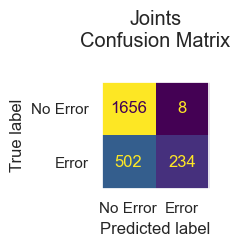

In [170]:
single_confusion(df_model_joints_test, result_dir, "Joints", "joints_together.png")
plt.show()

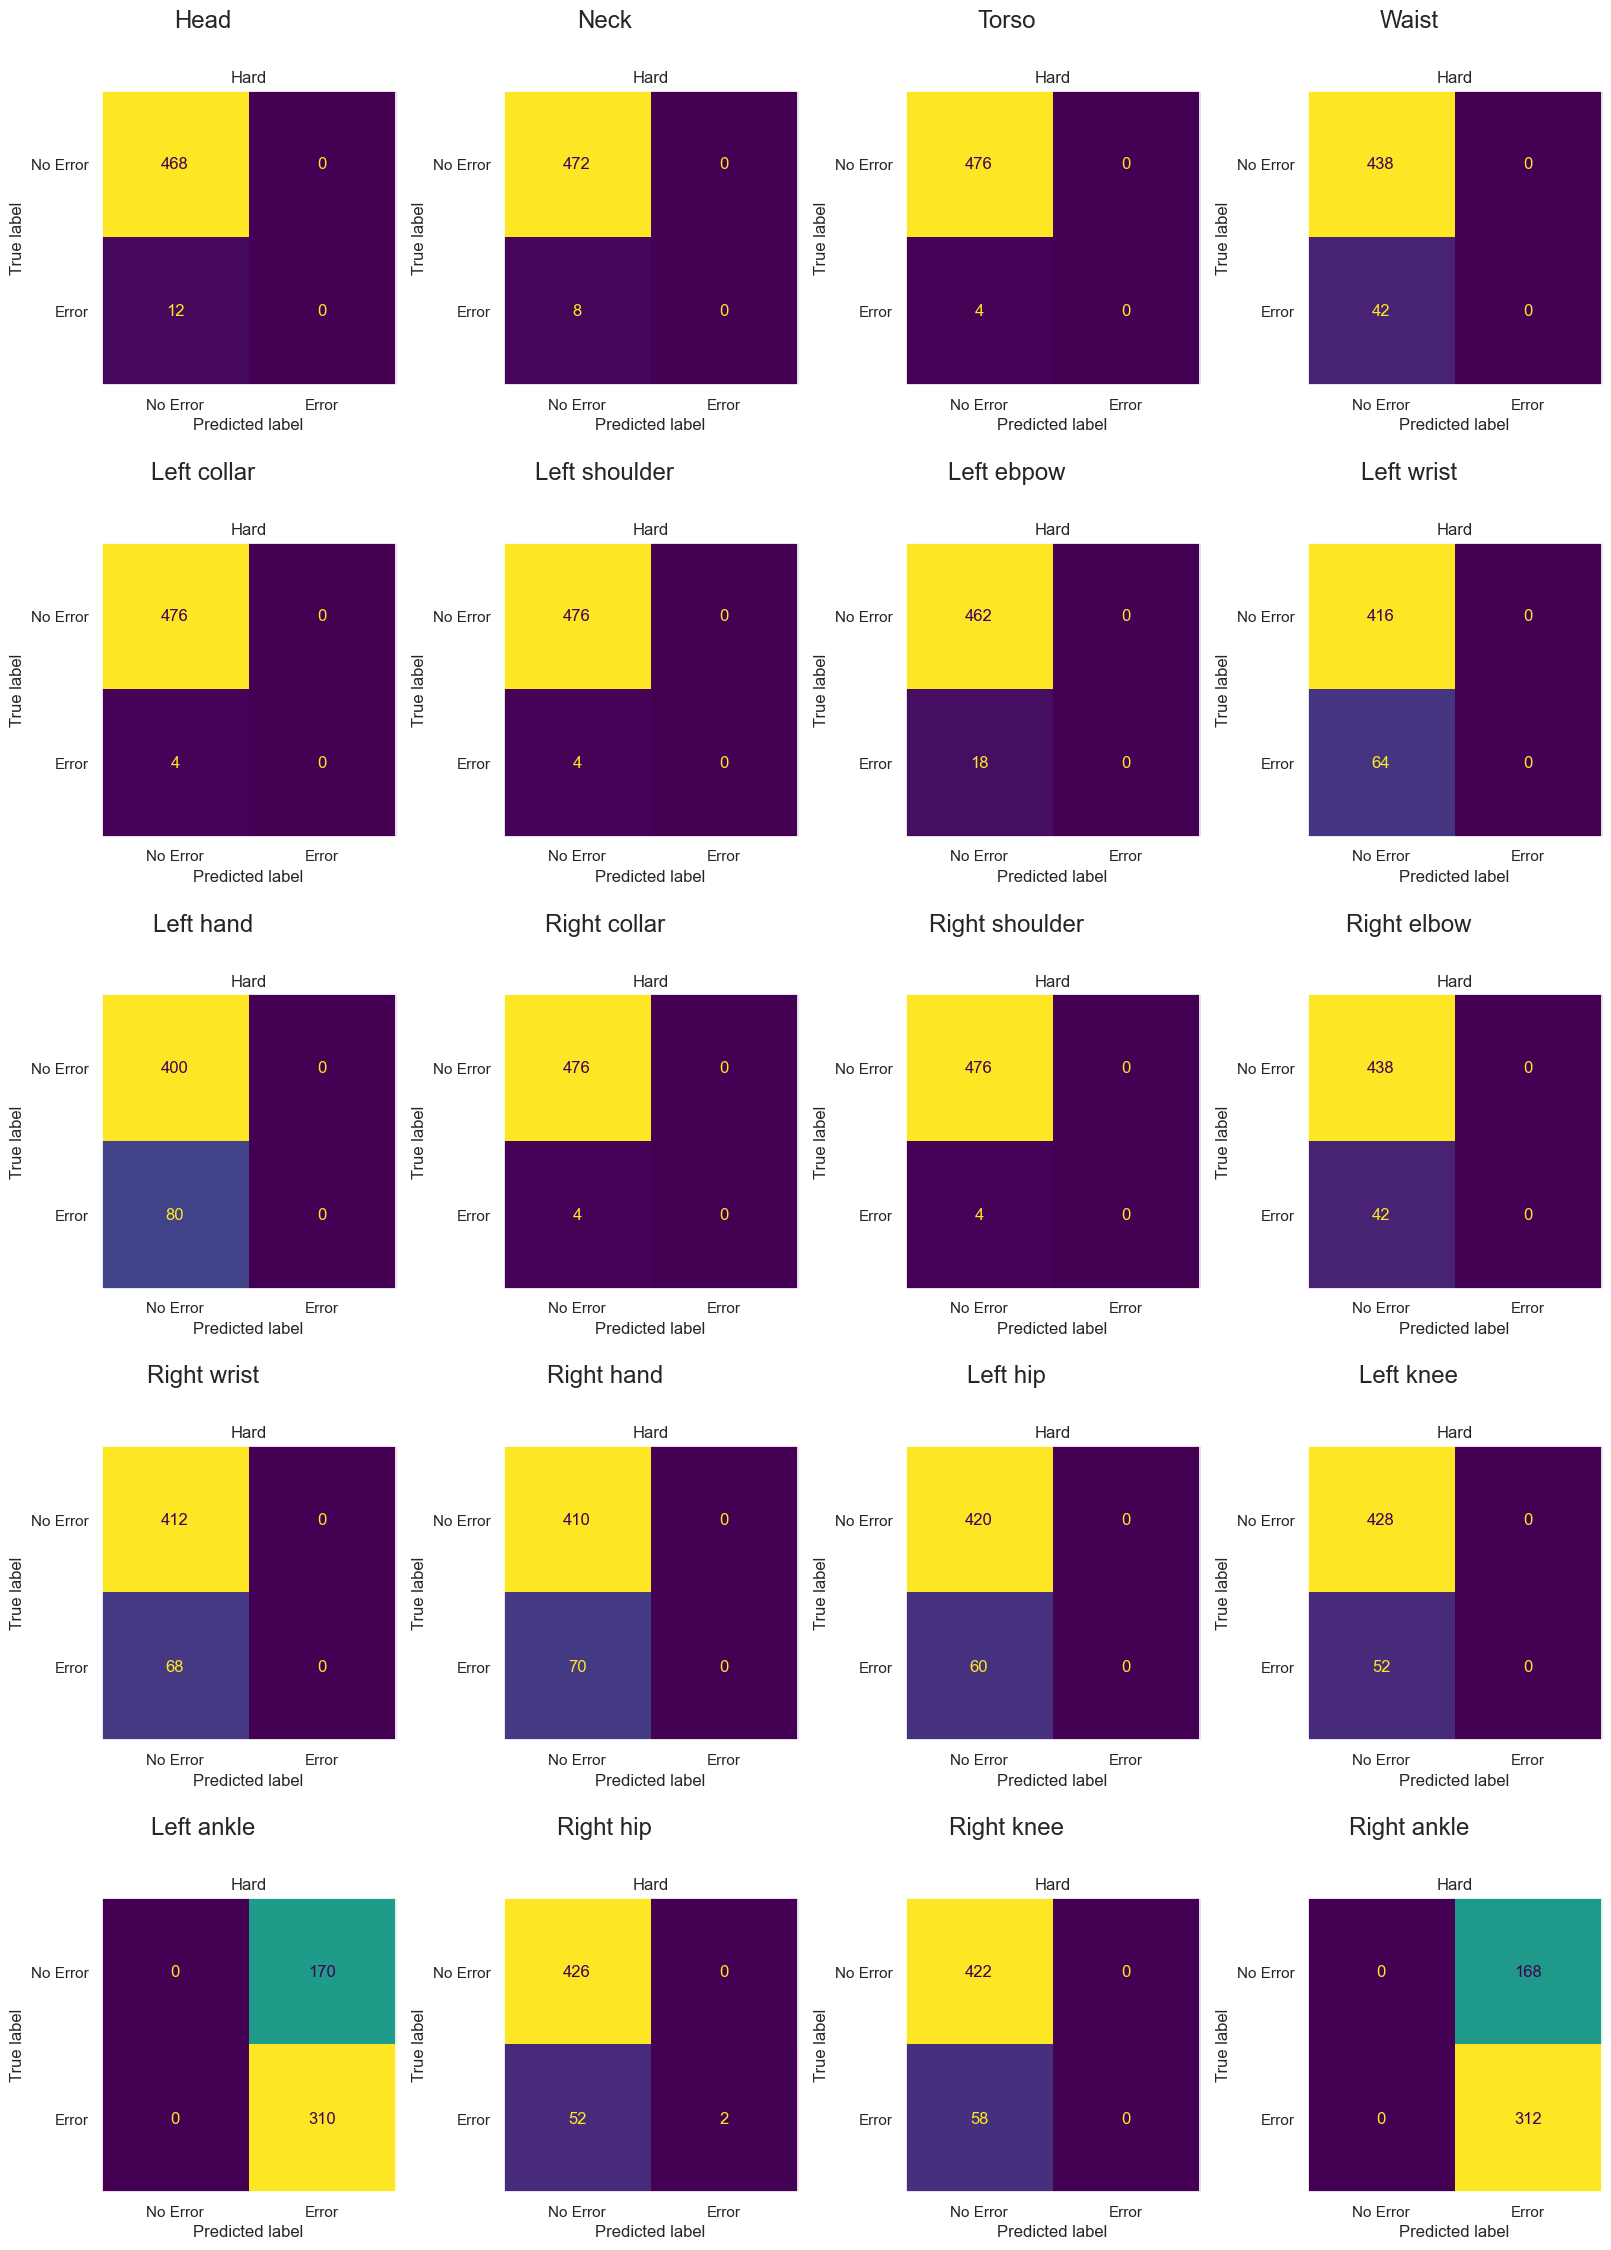

In [151]:
rows = 5
cols = 4
assert rows * cols == len(joint_names)

figure = plt.figure(layout='constrained', figsize=(4 * cols, 4.5 * rows))
subfigs = figure.subfigures(rows, cols)

for i, body_part in enumerate(joint_names):
  axs = subfigs.flatten()[i].subplots(1, 1)
  subfigs.flatten()[i].suptitle(body_part, fontsize='x-large')

  crit = df_model_joints_test["joint_names"] == body_part
  gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_joints_test[crit]["gts"].values.tolist()]
  preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_joints_test[crit]["preds"].values.tolist()]

  cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
  disp.plot(ax=axs, colorbar=False)

  axs.grid(False)
  axs.set_title(difficulty_names[difficulty])

#plt.tight_layout()
# plt.savefig(result_dir / "confusion/halves.png", dpi=300, bbox_inches='tight')
plt.show()

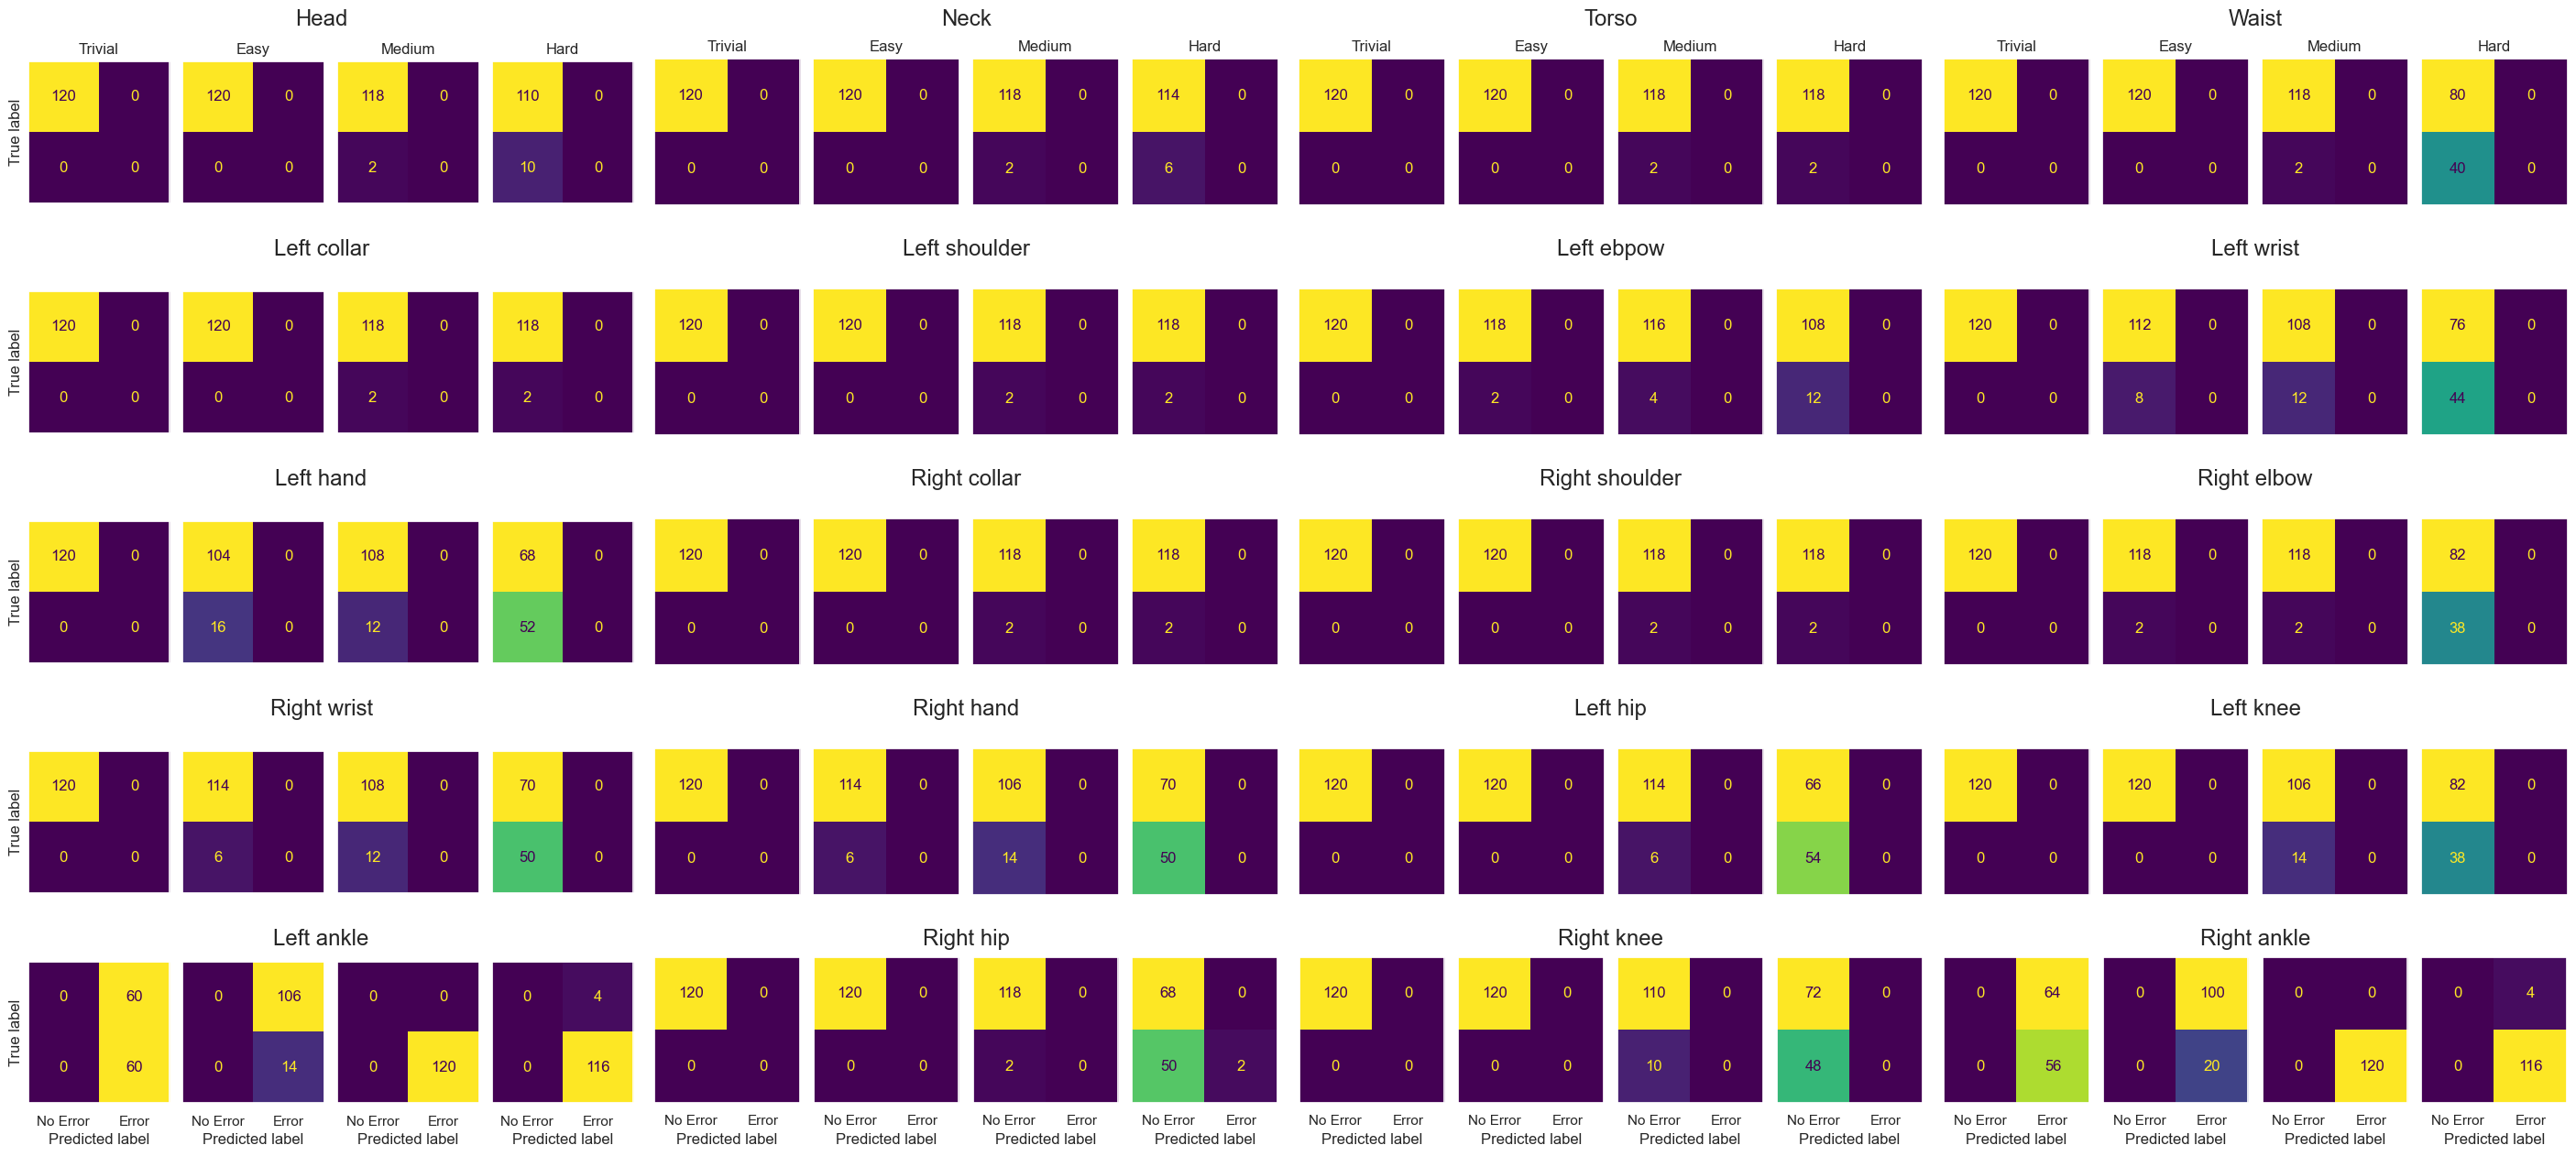

In [152]:
rows = 5
cols = 4
assert rows * cols == len(joint_names)

figure = plt.figure(layout='constrained', figsize=(7 * cols, 2.5 * rows))
subfigs = figure.subfigures(nrows=rows, ncols=cols)

difficulty_names = ["Trivial", "Easy", "Medium", "Hard"]
for i, joint_name in enumerate(joint_names):
  axs = subfigs.flatten()[i].subplots(1, 4, sharey=True)
  subfigs.flatten()[i].suptitle(joint_name, fontsize='x-large')
  for difficulty in [0, 1, 2, 3]:  
    crit_1 = df_model_joints_test["difficulty"] == difficulty
    crit_2 = df_model_joints_test["joint_names"] == joint_name
    crit = crit_1 & crit_2
    gts = ["No Error" if x[0] == 0 else "Error" for x in df_model_joints_test[crit]["gts"].values.tolist()]
    preds = ["No Error" if x[0] == 0 else "Error" for x in df_model_joints_test[crit]["preds"].values.tolist()]

    cm = confusion_matrix(gts, preds, labels=["No Error", "Error"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])
    disp.plot(ax=axs[difficulty], colorbar=False)

    axs[difficulty].grid(False)
    if i < cols:
      axs[difficulty].set_title(difficulty_names[difficulty])
    if i < (rows - 1) * cols:
      axs[difficulty].set_xlabel("") 
      axs[difficulty].set_xticks([]) 
    if difficulty != 0 or i % cols != 0:
      axs[difficulty].set_ylabel("")
      axs[difficulty].set_yticks([]) 

#plt.tight_layout()
plt.savefig(result_dir / "confusion/joints.png", dpi=300, bbox_inches='tight')
plt.show()

## ROC

In [181]:
from sklearn.metrics import roc_curve, roc_auc_score

In [239]:
def plot_roc_auc(y_true, y_score, ax, obj, i):
  if i == 0:
    ns_probs = [0 for _ in range(len(y_true))]
    ns_auc = roc_auc_score(y_true, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color="C0")
  lr_auc = roc_auc_score(y_true, y_score)
  # summarize scores
  print('ROC AUC=%.3f' % (lr_auc))
  # calculate roc curves
  lr_fpr, lr_tpr, _ = roc_curve(y_true, y_score)
  # plot the roc curve for the model
  plt.plot(lr_fpr, lr_tpr, marker='.', label=obj, color=f"C{i+1}")
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()

### Full Body

ROC AUC=0.502


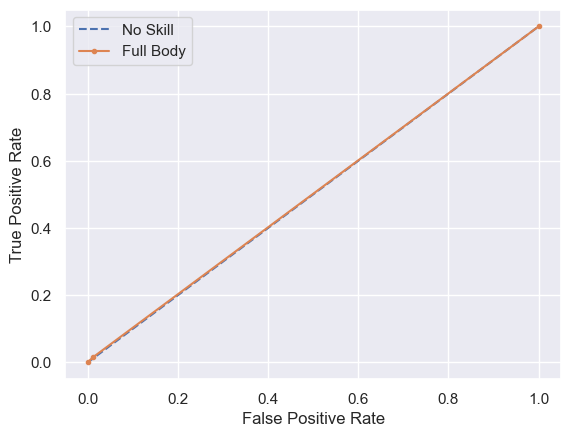

In [248]:
fig, ax = plt.subplots()

df_fb = df_model[df_model["mode"] == Mode.FULL_BODY]
df_fb = df_fb[df_fb["train_test"] == "test"]
df_fb = df_fb[df_fb["epoch"] == 100]
y_true = (df_fb["gts"].apply(lambda x: int(x[0]))).to_list()
y_score = (df_fb["confidences"].apply(lambda x: int(x[0]))).to_list()

plot_roc_auc(y_true, y_score, ax, "Full Body", 0)
plt.show()

## Half Body

ROC AUC=0.503
ROC AUC=0.553


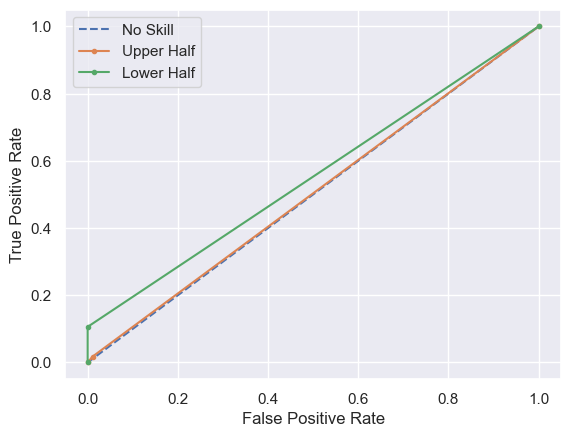

In [240]:
for i, obj in enumerate(body_halves):
  df_hb = df_model[df_model["mode"] == Mode.HALF_BODY]
  df_hb = df_hb[df_hb["joint_id"] == i]
  df_hb = df_hb[df_hb["train_test"] == "test"]
  df_hb = df_hb[df_hb["epoch"] == 100]
  y_true = (df_hb["gts"].apply(lambda x: 1 if int(x[0]) == 2 else int(x[0]))).to_numpy()
  y_score = (df_hb["confidences"].apply(lambda x: int(x[0]))).to_numpy()

  plot_roc_auc(y_true, y_score, ax, obj, i)
plt.show()

## Body Parts

ROC AUC=0.482
ROC AUC=0.427
ROC AUC=0.490
ROC AUC=0.480
ROC AUC=0.468
ROC AUC=0.460


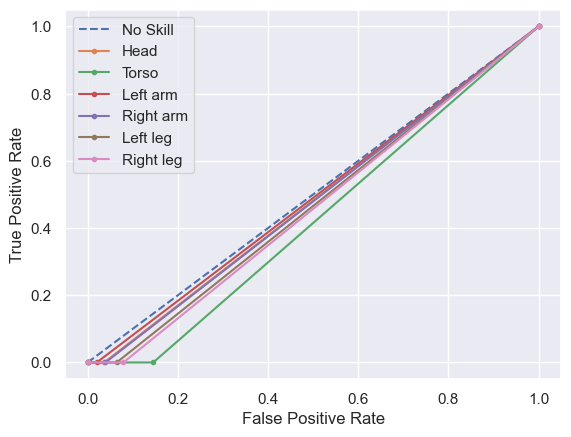

In [242]:
for i, obj in enumerate(body_parts):
  df = df_model[df_model["mode"] == Mode.BODY_PARTS]
  df = df[df["joint_id"] == i]
  df = df[df["train_test"] == "test"]
  df = df[df["epoch"] == 100]
  y_true = (df["gts"].apply(lambda x: 1 if int(x[0]) == 2 else int(x[0]))).to_numpy()
  y_score = (df["confidences"].apply(lambda x: int(x[0]))).to_numpy()

  plot_roc_auc(y_true, y_score, ax, obj, i)
plt.show()

ROC AUC=0.506
ROC AUC=0.502
ROC AUC=0.502
ROC AUC=0.514
ROC AUC=0.515
ROC AUC=0.506
ROC AUC=0.451
ROC AUC=0.505
ROC AUC=0.510
ROC AUC=0.500
ROC AUC=0.506
ROC AUC=0.476
ROC AUC=0.510
ROC AUC=0.481
ROC AUC=0.493
ROC AUC=0.507
ROC AUC=0.494
ROC AUC=0.493
ROC AUC=0.495
ROC AUC=0.500


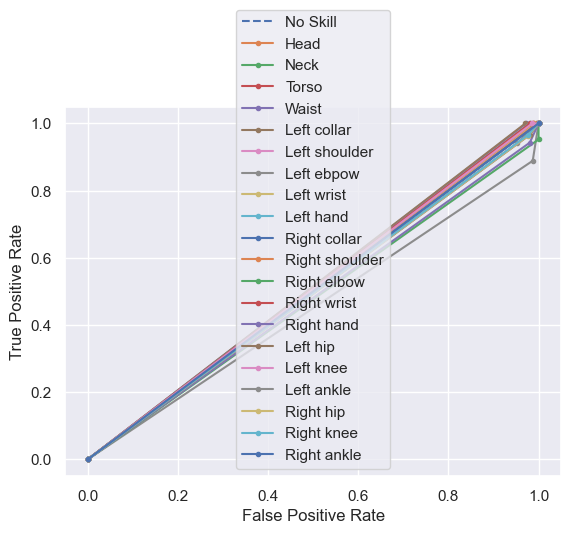

In [244]:
for i, obj in enumerate(joint_names):
  df = df_model[df_model["mode"] == Mode.JOINTS]
  df = df[df["joint_id"] == i]
  df = df[df["train_test"] == "test"]
  df = df[df["epoch"] == 100]
  y_true = (df["gts"].apply(lambda x: 1 if int(x[0]) >= 2 else int(x[0]))).to_numpy()
  y_score = (df["confidences"].apply(lambda x: int(x[0]))).to_numpy()

  plot_roc_auc(y_true, y_score, ax, obj, i)
plt.show()